In [9]:
# Load libraries.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime as dt
import re

import plotly.express as px

import pandas_datareader.data as web
from pandas_datareader import data as pdr

import yfinance as yf

(
    yf
    .pdr_override()
)

import warnings
warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(230926)

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

from tabulate import tabulate

%matplotlib inline

In [26]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# ENSEMBLE

## Bagging
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsRegressor

# Multi-layer Perceptron (Neural Networks)
from sklearn.neural_network import MLPRegressor

In [28]:
# for data split
from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import PolynomialFeatures

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

In [12]:
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

In [13]:
from pandas.plotting import scatter_matrix

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf

#### We have defined a Backtesting Class below which is used across strategies for Backtesting and generate stats

In [14]:
class Backtest:
    def __init__(self,data, base_, tradingexp_):
        self.data=data
        self.base=base_
        self.tradingexp = tradingexp_
        ## Write any processing that needs to be done on the data
        self.data['Buy_Sell']= self.data['Position'] - self.data['Position'].shift(1)
        self.data['log_return']=np.log(self.data['Adj Close']/self.data['Adj Close'].shift(1))
        self.data['Strategy_return']=self.data['Position'].shift(1)*self.data['log_return']
        self.data['Expense']=np.where(abs(self.data['Buy_Sell'])> 0, self.tradingexp, 0)
        self.data['Capital']= self.base*self.data['Strategy_return'].cumsum().apply(np.exp)
        self.data['Adj Capital'] = self.base*self.data['Strategy_return'].cumsum().apply(np.exp) - self.data['Expense'].shift(1).cumsum()
        self.data['Adj return'] = np.log(self.data['Adj Capital']/self.data['Adj Capital'].shift(1))
        self.data['drawdown']=self.data['Adj return'].cumsum() - self.data['Adj return'].cumsum().cummax()

                
    def plot_backtest_buy_sell(self): 
        ax=\
        (
            self.data[['Adj Close',
                       'Position']]
            .plot(figsize=(18,8),
                  secondary_y=["Position"],
                  style=["red","b--"],
                  alpha=0.5
                 )
        )

        (
            ax.legend(loc="upper center"
                      ,shadow=True
                      ,fancybox=True
                      ,bbox_to_anchor=(0.55,1.10)
                      ,ncol=4
                     )
        )

        bx=\
        (
            self.data[self.data['Buy_Sell']>0]['Adj Close']
            .plot(style="g^",
                  markersize=12,
                  label='Buy')
        )

        bx.legend()

        cx=\
        (
            self.data[self.data['Buy_Sell']<0]['Adj Close']
            .plot(style="rv",
                  markersize=12,
                  label="Sell")
        )
        
        cx.legend()
        plt.title(f"Backtest Buy Sell Signals")
        plt.show()
      
    def calculate_cumm_return(self):
        res=100*(np.exp(self.data['Adj return'].sum()) -1)
        return res
    
    def calculate_max_drawdown(self):
        res=100* (np.exp(self.data['drawdown'].min()) - 1)
        return res
    
    def calculate_max_drawdown_duration(self):
        periods =\
        self.data[self.data['drawdown'] == 0].index[ 1 :   ].to_pydatetime() \
        - self.data[self.data['drawdown'] == 0].index[   : -1].to_pydatetime()
        print(f"Max Drawdown Duration: {periods.max()}")

    def calculate_return_byyear(self):
        grpByYear=self.data.groupby(self.data.index.year)
        return grpByYear['Adj return'].sum().apply(np.exp) -1

    def calculate_sharpe_ratio(self):
        res = np.sqrt(252) * (self.data['Adj return'].dropna().apply(np.exp).add(-1).mean()) / (self.data['Adj return'].dropna().apply(np.exp).add(-1).std())
        return res
    
    def calculate_sortino_ratio(self):
        res= np.sqrt(252) * (self.data['Adj return'].dropna().apply(np.exp).add(-1).mean()) / np.minimum(self.data['Adj return'].dropna().apply(np.exp).add(-1),0).std()
        return res

    def calculate_cagr(self):
        days =(self.data.index[-1] - self.data.index[0]).days
        CAGR =100*(((np.exp(self.data['Adj return'].sum()))**(365.0/days)) - 1)
        return CAGR
        
    def generate_quarterly_returns(self):
        self.data['quarter'] = self.data.index.quarter
        self.data['year'] = self.data.index.year
        result =\
        (
            self.data
            .groupby(['quarter', 'year'])['Adj return']
            .sum()
            .apply(np.exp)
            .add(-1)
            .multiply(100)
            .reset_index(name='Cumulative Return')
        )

        pivot=result.pivot(index='year', columns='quarter', values='Cumulative Return')
        pivot.columns=pivot.columns.map(lambda x: 'Q' + str(x))
        pivot=pivot.round(decimals=5)
        return pivot
        
    def plot_backtest_returns(self):
        ax =\
        (
            self.data[["log_return", "Adj return"]]
            .dropna()
            .cumsum()
            .apply(np.exp)
            .add(-1)
            .plot(figsize = [18, 7])
        )
        
        ax.set_title(f"Back Test Strategy vs Buy & Hold Return")
        ax.legend(["Buy & Hold Cumm Return","Strategy Cumm Return"])
        bx =\
        (
            self.data['Adj return']
            .cumsum()
            .cummax()
            .apply(np.exp)
            .add(-1)
            .plot(ax=ax)
        )
        plt.show()
    
    def plot_all_stats(self):
    
        portfolio_stats = pd.DataFrame({
            'Final Account Balance': f"$ {self.data['Adj Capital'].iloc[-1]:,.2f}",
            'Cummulative return': f"{self.calculate_cumm_return():.2f}%",
            'Strategy CAGR': f"{self.calculate_cagr():.2f}%",
            'Max Drawdown': f"{self.calculate_max_drawdown():.2f}%",
            'Sharpe Ratio': f"{self.calculate_sharpe_ratio():.3f}",
            'Sortino Ratio': f"{self.calculate_sortino_ratio():.3f}"
        }, index=['Value'])

        portfolio_stats.columns.name='Statistic'
        print(tabulate(portfolio_stats.transpose(), headers='keys', tablefmt='pretty', showindex=True,stralign='right'))
        self.plot_backtest_returns()
        print('% Return by Quarter:')
        print(tabulate(self.generate_quarterly_returns(), headers='keys', tablefmt='pretty', showindex=True,stralign='right'))
        self.plot_backtest_buy_sell()


# Table of Contents

## [Strategy 1](#strategy_1)
## [Strategy 2](#strategy_2)
## [Strategy 3](#strategy_3)
## [Strategy 4](#strategy_4)
## [Strategy 5](#strategy_5)
## [Part 4 Analysis Survivorship Bias](#Part_4_Analysis_Survivorship_Bias)
## [Part 4 Analysis Market Regime Change](#Part_4_Analysis_MarketRegime)

<a id='strategy_1'></a>

# Strategy 1: Supervised Machine Learning using CART

### Supervised learning of logistic regression and decision tree (CART). Focusing on feature engineering and hyperparameter tuning with long & short directional bets

In [15]:
capital = 1e5
start_date = dt.datetime(2004,11,1)
end_date = dt.datetime(2023,11,1)
spy = pdr.get_data_yahoo("SPY", start = start_date, end = end_date)

Y = np.log(spy["Adj Close"]).diff(1).shift(-1)            
Y.name = "Y_pred"

tnx_ticker = "^TNX" # CBOE 10 Year Treasury Note Yield Index
tnx_data = yf.download(tnx_ticker, start=start_date, end=end_date)

X1 = np.log(tnx_data['Adj Close'])
X1 = X1.ffill()
X1.name='10years futures'

vix_ticker = "^VIX"
vix = yf.download(vix_ticker, start=start_date, end=end_date)
X2 = np.log(vix['Adj Close'])
X2 = X2.ffill()
X2.name='vix'

X3 = np.log(spy['Volume'])

X4 = pd.concat([X1.shift(i) for i in [3,6,12]], axis=1)
X4.columns = ["Volume_3", "Volume_6", "Volume_12"]

X5 = pd.concat([Y.diff(i) for i in [3,6,12]], axis=1)
X5.columns = ["SPY_3", "SPY_6", "SPY_12"]

X = pd.concat([X1, X2, X3, X4, X5], axis=1)

X_traintest = X.loc[pd.to_datetime('2004-11-17'):]
X_traintest = X_traintest.ffill()

Y_traintest = Y.loc[pd.to_datetime('2004-11-17'):]

Y_traintest_binary = (Y_traintest > 0).astype(int)
index_ = Y_traintest_binary.index

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<Axes: >

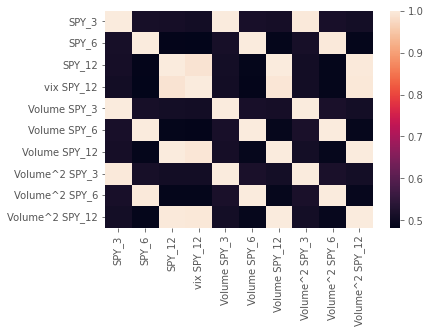

In [16]:
def get_polynomial_features(X_traintest, Y_traintest, *args):
    
    k = arg[0] if args else "all"
    
    Y_traintest_binary = (Y_traintest > 0).astype(int)
    
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X_traintest)

    feature_names = poly.get_feature_names_out(input_features=['10years futures', 'vix', 'Volume', 'Volume_3', 'Volume_6', 'Volume_12', 'SPY_3', 'SPY_6', 'SPY_12'])
    X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
    X_poly_df.index = index_
    
    selector = SelectKBest(score_func=f_regression, k=k) 

    X_selected = selector.fit_transform(X_poly_df, Y_traintest_binary) #Y_traintest_binary
    X_columns = selector.get_feature_names_out()
    X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = index_)
    
#from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_traintest)

feature_names = poly.get_feature_names_out(input_features=['10years futures', 'vix', 'Volume', 'Volume_3', 'Volume_6', 'Volume_12', 'SPY_3', 'SPY_6', 'SPY_12'])
X_poly_df = pd.DataFrame(X_poly, columns=feature_names, index = index_)

# select the top 10 features based on the F-scores, arbitrary user-input before optimization
selector = SelectKBest(score_func=f_regression, k=10) 

X_selected = selector.fit_transform(X_poly_df, Y_traintest_binary) #Y_traintest_binary
X_columns = selector.get_feature_names_out()
X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = index_)

sns.heatmap(X_selected_df.corr())

In [17]:
X_selected_df.head()

SPY_3     SPY_6    SPY_12  vix SPY_12  Volume SPY_3  \
Date                                                                 
2004-11-17 -0.001105  0.000580  0.000996    0.002571     -0.019690   
2004-11-18 -0.003994 -0.018759 -0.023694   -0.060737     -0.069001   
2004-11-19 -0.001163 -0.003102 -0.008805   -0.022916     -0.020709   
2004-11-22  0.000176 -0.000930 -0.004719   -0.012094      0.003065   
2004-11-23  0.013546  0.009552  0.003818    0.009694      0.237763   

            Volume SPY_6  Volume SPY_12  Volume^2 SPY_3  Volume^2 SPY_6  \
Date                                                                      
2004-11-17      0.010325       0.017744       -0.350743        0.183930   
2004-11-18     -0.324097      -0.409350       -1.192106       -5.599324   
2004-11-19     -0.055246      -0.156808       -0.368821       -0.983905   
2004-11-22     -0.016213      -0.082312        0.053466       -0.282775   
2004-11-23      0.167661       0.067009        4.173316        2.942852   

            Volume^2 SPY_12  
Date                         
2004-11-17         0.316077  
2004-11-18        -7.072212  
2004-11-19        -2.792693  
2004-11-22        -1.435635  
2004-11-23         1.176164

In [18]:
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.metrics import mean_squared_error

DT_model = DecisionTreeRegressor(criterion='squared_error')
get_polynomial_features(X_traintest, Y_traintest)

DT_model.fit(X_selected_df, Y_traintest.ffill())
DT_pred_train2 = DT_model.predict(X_selected_df)
train_result_mse = mean_squared_error(Y_traintest.ffill(), DT_pred_train2)
print('Mean Squared Error = ', train_result_mse)

DT_pred_train2_df = pd.DataFrame(DT_pred_train2, index=index_, )

X_traintest_dt = X_selected_df.copy()
X_traintest_dt['signal'] = DT_pred_train2_df
X_traintest_dt['signal'] = np.sign(X_traintest_dt['signal'])

Mean Squared Error =  0.0


strategy final balance =  1.354526419524815e+21


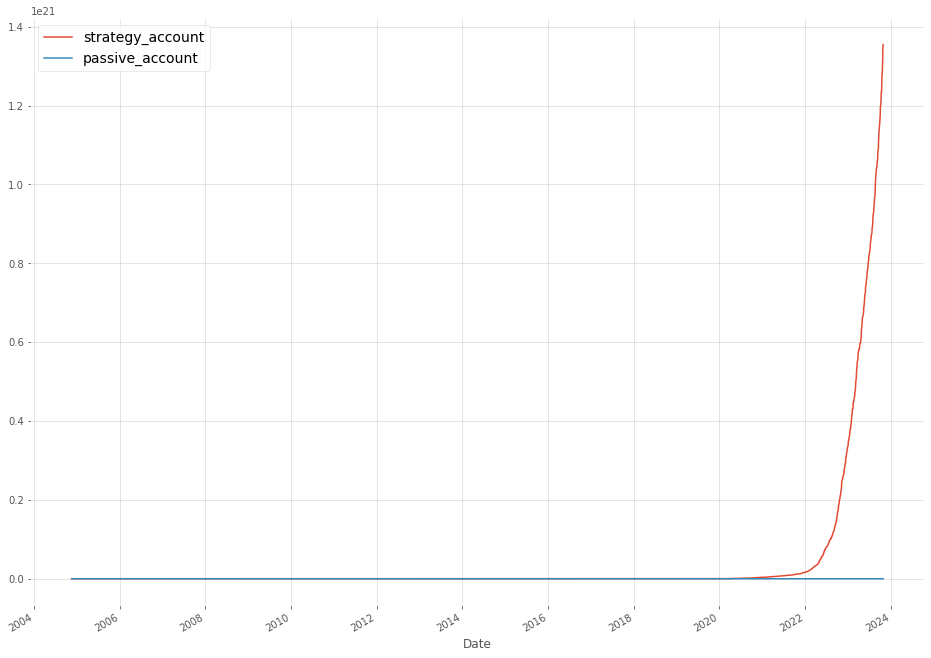

In [19]:
X_traintest_dt['strategy_return'] = X_traintest_dt["signal"] * Y
X_traintest_dt['strategy_account'] = X_traintest_dt['strategy_return'].cumsum().apply(np.exp) * capital
X_traintest_dt['passive_account'] = Y.cumsum().apply(np.exp) * capital

fig, ax1 = plt.subplots(figsize = [16,12])
X_traintest_dt['strategy_account'].plot(ax=ax1, label='strategy_account')
X_traintest_dt['passive_account'].plot(ax=ax1, label='passive_account')
ax1.legend()

print('strategy final balance = ', X_traintest_dt['strategy_account'].dropna()[-1])

In [20]:
reporting_df4=pd.concat([spy["Adj Close"],X_traintest_dt["signal"]],axis=1)
reporting_df4.columns=['Adj Close','Position']

+-----------------------+------------------------------------+
|             Statistic |                              Value |
+-----------------------+------------------------------------+
| Final Account Balance | $ 1,354,526,419,524,834,295,808.00 |
|    Cummulative return |            1352700979930203136.00% |
|         Strategy CAGR |                            605.74% |
|          Max Drawdown |                              0.00% |
|          Sharpe Ratio |                             12.964 |
|         Sortino Ratio |                                inf |
+-----------------------+------------------------------------+


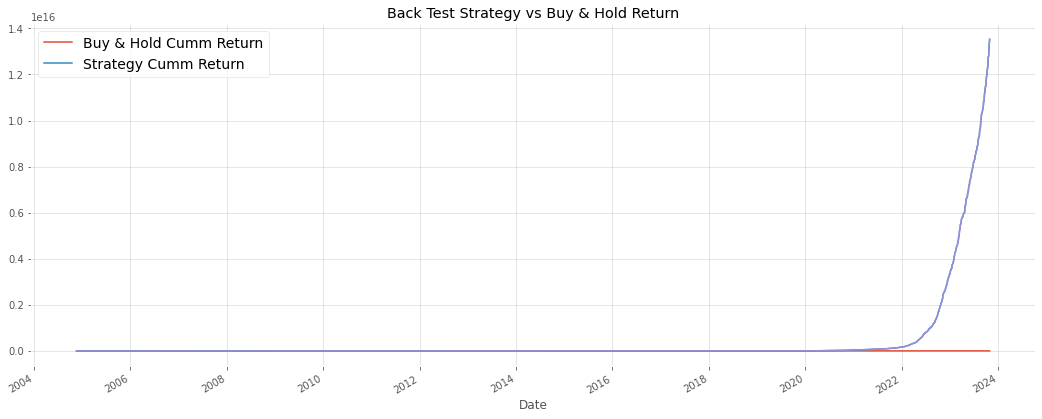

% Return by Quarter:
+------+-----------+-----------+-----------+-----------+
| year |        Q1 |        Q2 |        Q3 |        Q4 |
+------+-----------+-----------+-----------+-----------+
| 2004 |       nan |       nan |       nan |  10.85105 |
| 2005 |   38.1209 |  43.07662 |  33.83762 |  38.30613 |
| 2006 |  33.17769 |  48.63619 |  32.10273 |  24.20805 |
| 2007 |  36.36056 |  37.58539 |  75.12307 |  85.72748 |
| 2008 | 101.93829 |  60.72365 | 159.72814 |   773.384 |
| 2009 | 236.27892 | 122.46948 |  67.34987 |  65.47248 |
| 2010 |  49.76804 | 107.80521 |  70.23887 |  38.60023 |
| 2011 |  47.73979 |  48.33993 | 165.88279 | 130.16329 |
| 2012 |  33.99676 |  66.76026 |  37.55484 |  43.38765 |
| 2013 |  33.46005 |  58.42437 |  33.11592 |  38.61159 |
| 2014 |  41.01277 |  32.54772 |  32.09348 |  51.36535 |
| 2015 |  54.25416 |  36.02146 |   79.9257 |  59.85227 |
| 2016 |  72.08219 |   48.0973 |  30.88441 |   28.9105 |
| 2017 |  22.44897 |  22.92298 |  19.96178 |  19.05957 |
| 2018 |  

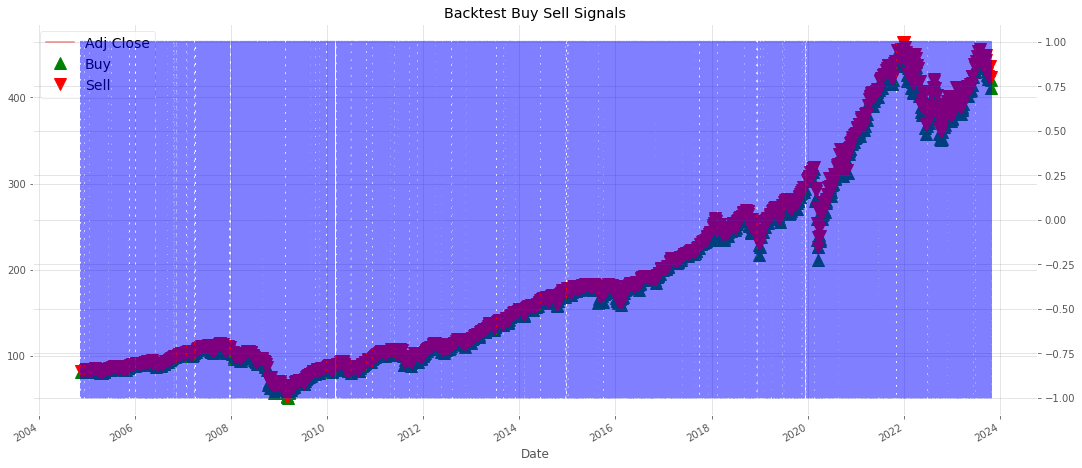

In [21]:
#Generate Stats
Backtest_Strategy4=Backtest(reporting_df4,100000,0)
Backtest_Strategy4.plot_all_stats()

### ~Strategy 1 Ends

<a id='strategy_2'></a>

# Strategy 2: Supervised Machine Learning using ERT and LASSO
### Using Other global indices together with Crude Oil Prices, Bond and S&P futures to fit Machine Learning models to predict and trade on SPY.

### 1. Data Sourcing

In [7]:
start="2004-11-1"
end="2023-11-1"

stock_ticker = ["SPY",'^VIX','ES=F','CL=F','IEF','ZB=F']

currency_ticker = ["DEXJPUS", "DEXUSUK"]

index_ticker = ["^IXIC", "DJIA", "^GDAXI","^HSI","^N225"]


stock_data = pdr.get_data_yahoo(stock_ticker,start=start,end=end)
#currency_data = pdr.get_data_fred(currency_ticker)
index_data = pdr.get_data_yahoo(index_ticker,start=start,end=end)

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  5 of 5 completed


In [8]:
stock_data

Adj Close                                                         \
                 CL=F     ES=F        IEF         SPY        ZB=F       ^VIX   
Date                                                                           
2004-11-01  50.130001  1130.75  52.784004   78.617935  113.125000  16.270000   
2004-11-02  49.619999  1130.50  52.913181   78.645676  113.250000  16.180000   
2004-11-03  50.880001  1145.00  52.894772   79.636047  113.437500  14.040000   
2004-11-04  48.820000  1160.50  52.864006   80.723427  113.593803  13.970000   
2004-11-05  49.610001  1167.75  52.470154   81.229073  112.250000  13.840000   
...               ...      ...        ...         ...         ...        ...   
2023-10-25  85.389999  4209.75  89.011925  417.549988  108.406250  20.190001   
2023-10-26  83.209999  4156.50  89.690033  412.549988  109.875000  20.680000   
2023-10-27  85.540001  4137.75  89.829643  410.679993  109.500000  21.270000   
2023-10-30  82.309998  4185.75  89.530472  415.589996  109.281250  19.750000   
2023-10-31  81.019997  4212.25  89.340996  418.200012  109.437500  18.139999   

                Close                                  ...       Open  \
                 CL=F     ES=F        IEF         SPY  ...        IEF   
Date                                                   ...              
2004-11-01  50.130001  1130.75  85.779999  113.510002  ...  86.059998   
2004-11-02  49.619999  1130.50  85.989998  113.550003  ...  85.809998   
2004-11-03  50.880001  1145.00  85.959999  114.980003  ...  85.519997   
2004-11-04  48.820000  1160.50  85.910004  116.550003  ...  86.099998   
2004-11-05  49.610001  1167.75  85.269997  117.279999  ...  85.309998   
...               ...      ...        ...         ...  ...        ...   
2023-10-25  85.389999  4209.75  89.260002  417.549988  ...  89.580002   
2023-10-26  83.209999  4156.50  89.940002  412.549988  ...  89.349998   
2023-10-27  85.540001  4137.75  90.080002  410.679993  ...  89.870003   
2023-10-30  82.309998  4185.75  89.779999  415.589996  ...  89.639999   
2023-10-31  81.019997  4212.25  89.589996  418.200012  ...  89.830002   

                                                 Volume             \
                   SPY        ZB=F       ^VIX      CL=F       ES=F   
Date                                                                 
2004-11-01  113.559998  113.875000  16.430000  133138.0   494666.0   
2004-11-02  113.669998  113.250000  15.990000   82754.0   831105.0   
2004-11-03  115.029999  113.625000  15.050000  143701.0   981514.0   
2004-11-04  114.779999  113.312500  13.830000  121094.0   897586.0   
2004-11-05  117.050003  113.531303  13.670000  115766.0   833448.0   
...                ...         ...        ...       ...        ...   
2023-10-25  421.890015  110.281250  19.389999  429459.0  1981633.0   
2023-10-26  416.450012  108.406250  21.780001  341792.0  2419407.0   
2023-10-27  414.190002  109.781250  20.389999  333760.0  2195767.0   
2023-10-30  413.559998  109.687500  21.129999  356928.0  1904610.0   
2023-10-31  416.179993  109.000000  19.860001  346007.0  1836212.0   

                                                    
                   IEF          SPY      ZB=F ^VIX  
Date                                                
2004-11-01    128800.0   36720900.0  147349.0  0.0  
2004-11-02    191300.0   56210000.0  427746.0  0.0  
2004-11-03    139800.0   76960200.0  269523.0  0.0  
2004-11-04    435100.0   55350300.0  420930.0  0.0  
2004-11-05    886400.0   63287200.0  190298.0  0.0  
...                ...          ...       ...  ...  
2023-10-25  15170200.0   94223200.0  506995.0  0.0  
2023-10-26  15901300.0  115156800.0  596519.0  0.0  
2023-10-27  11628200.0  107367700.0  394682.0  0.0  
2023-10-30  11022500.0   86562700.0  441993.0  0.0  
2023-10-31  11574700.0   79665200.0  725179.0  0.0  

[4792 rows x 36 columns]

In [9]:
index_data.tail()

Adj Close                                                          \
                 DJIA        ^GDAXI          ^HSI         ^IXIC         ^N225   
Date                                                                            
2023-10-25  20.980000  14892.179688  17085.330078  12821.219727  31269.919922   
2023-10-26  20.950001  14731.049805  17044.609375  12595.610352  30601.779297   
2023-10-27  20.820000  14687.410156  17398.730469  12643.009766  30991.689453   
2023-10-30  20.990000  14716.540039  17406.359375  12789.480469  30696.960938   
2023-10-31  21.200001  14810.339844  17112.480469  12851.240234  30858.849609   

                Close                                                          \
                 DJIA        ^GDAXI          ^HSI         ^IXIC         ^N225   
Date                                                                            
2023-10-25  20.980000  14892.179688  17085.330078  12821.219727  31269.919922   
2023-10-26  20.950001  14731.049805  17044.609375  12595.610352  30601.779297   
2023-10-27  20.820000  14687.410156  17398.730469  12643.009766  30991.689453   
2023-10-30  20.990000  14716.540039  17406.359375  12789.480469  30696.960938   
2023-10-31  21.200001  14810.339844  17112.480469  12851.240234  30858.849609   

            ...       Open                                            \
            ...       DJIA        ^GDAXI          ^HSI         ^IXIC   
Date        ...                                                        
2023-10-25  ...  21.010000  14870.629883  17465.429688  13039.860352   
2023-10-26  ...  21.059999  14696.219727  17085.119141  12768.969727   
2023-10-27  ...  20.990000  14757.110352  17160.230469  12718.690430   
2023-10-30  ...  20.910000  14770.950195  17225.650391  12750.469727   
2023-10-31  ...  21.049999  14741.440430  17337.699219  12786.620117   

                           Volume                                           \
                   ^N225     DJIA       ^GDAXI          ^HSI         ^IXIC   
Date                                                                         
2023-10-25  31302.509766   6600.0   88086100.0  2.499934e+09  4.599850e+09   
2023-10-26  30902.919922  43600.0  121803600.0  1.967216e+09  4.894900e+09   
2023-10-27  30713.789062  15400.0   86539200.0  2.452090e+09  4.172100e+09   
2023-10-30  30663.480469  16100.0   76179000.0  2.665231e+09  4.149320e+09   
2023-10-31  30694.960938   9300.0   75370200.0  2.112804e+09  4.315630e+09   

                         
                  ^N225  
Date                     
2023-10-25   78700000.0  
2023-10-26   85600000.0  
2023-10-27   89100000.0  
2023-10-30  187000000.0  
2023-10-31  134300000.0  

[5 rows x 30 columns]

In [10]:
## We optimized return period by running an iteration for different values of return period from 5 to 50 
## in multiples of 5

return_period = 5

In [11]:
Y =\
    (stock_data.loc[ : , ("Adj Close", "SPY")]
     .diff(return_period)
     .shift(-return_period)
    )
Y

Date
2004-11-01    2.493370
2004-11-02    2.306343
2004-11-03    1.378304
2004-11-04    0.907341
2004-11-05    1.045815
                ...   
2023-10-25         NaN
2023-10-26         NaN
2023-10-27         NaN
2023-10-30         NaN
2023-10-31         NaN
Name: (Adj Close, SPY), Length: 4792, dtype: float64

In [12]:
Y.name =\
    (Y
     .name[-1]
     +
     "_pred")

Y

Date
2004-11-01    2.493370
2004-11-02    2.306343
2004-11-03    1.378304
2004-11-04    0.907341
2004-11-05    1.045815
                ...   
2023-10-25         NaN
2023-10-26         NaN
2023-10-27         NaN
2023-10-30         NaN
2023-10-31         NaN
Name: SPY_pred, Length: 4792, dtype: float64

In [13]:
X1 =\
    (stock_data.loc[ : , ("Adj Close", ("CL=F", "ES=F","IEF","ZB=F","^VIX")
                             )
                       ]
     .diff(return_period)
    )

X1.columns =\
    (X1
     .columns
     .droplevel()
    )

X1

CL=F    ES=F       IEF     ZB=F      ^VIX
Date                                                     
2004-11-01       NaN     NaN       NaN      NaN       NaN
2004-11-02       NaN     NaN       NaN      NaN       NaN
2004-11-03       NaN     NaN       NaN      NaN       NaN
2004-11-04       NaN     NaN       NaN      NaN       NaN
2004-11-05       NaN     NaN       NaN      NaN       NaN
...              ...     ...       ...      ...       ...
2023-10-25 -2.930000 -132.50 -0.129631 -0.87500  0.970001
2023-10-26 -6.160004 -146.50  0.987259  2.03125 -0.719999
2023-10-27 -3.209999 -110.75  0.608307  1.03125 -0.439999
2023-10-30 -3.180000  -56.00 -0.109695 -0.68750 -0.620001
2023-10-31 -2.720001  -59.00 -0.458733 -0.56250 -0.830000

[4792 rows x 5 columns]

In [14]:
X2 =\
    (index_data.loc[ : , ("Adj Close", ("^GDAXI","^HSI","^IXIC","^N225")
                             )
                       ]
     .diff(return_period)
    )

X2.columns =\
    (X2
     .columns
     .droplevel()
    )

X2

^GDAXI        ^HSI       ^IXIC       ^N225
Date                                                      
2004-11-01         NaN         NaN         NaN         NaN
2004-11-02         NaN         NaN         NaN         NaN
2004-11-03         NaN         NaN         NaN         NaN
2004-11-04         NaN         NaN         NaN         NaN
2004-11-05         NaN         NaN         NaN         NaN
...                ...         ...         ...         ...
2023-10-25 -202.730469 -647.189453 -493.080078 -772.330078
2023-10-26 -314.180664 -251.281250 -590.569336 -828.839844
2023-10-27 -111.059570  226.599609 -340.799805 -267.669922
2023-10-30  -84.179688         NaN -228.849609 -302.589844
2023-10-31  -69.600586  120.951172 -288.629883 -203.500000

[4945 rows x 4 columns]

In [15]:
index_data

Adj Close                                                          \
                 DJIA        ^GDAXI          ^HSI         ^IXIC         ^N225   
Date                                                                            
2004-11-01        NaN   4012.639893  13094.250000   1979.869995  10734.709961   
2004-11-02        NaN   4037.570068  13308.740234   1984.790039  10887.809570   
2004-11-03        NaN   4039.040039  13397.669922   2004.329956           NaN   
2004-11-04        NaN   4041.379883  13369.089844   2023.630005  10946.269531   
2004-11-05        NaN   4063.580078  13494.950195   2038.939941  11061.769531   
...               ...           ...           ...           ...           ...   
2023-10-25  20.980000  14892.179688  17085.330078  12821.219727  31269.919922   
2023-10-26  20.950001  14731.049805  17044.609375  12595.610352  30601.779297   
2023-10-27  20.820000  14687.410156  17398.730469  12643.009766  30991.689453   
2023-10-30  20.990000  14716.540039  17406.359375  12789.480469  30696.960938   
2023-10-31  21.200001  14810.339844  17112.480469  12851.240234  30858.849609   

                Close                                                          \
                 DJIA        ^GDAXI          ^HSI         ^IXIC         ^N225   
Date                                                                            
2004-11-01        NaN   4012.639893  13094.250000   1979.869995  10734.709961   
2004-11-02        NaN   4037.570068  13308.740234   1984.790039  10887.809570   
2004-11-03        NaN   4039.040039  13397.669922   2004.329956           NaN   
2004-11-04        NaN   4041.379883  13369.089844   2023.630005  10946.269531   
2004-11-05        NaN   4063.580078  13494.950195   2038.939941  11061.769531   
...               ...           ...           ...           ...           ...   
2023-10-25  20.980000  14892.179688  17085.330078  12821.219727  31269.919922   
2023-10-26  20.950001  14731.049805  17044.609375  12595.610352  30601.779297   
2023-10-27  20.820000  14687.410156  17398.730469  12643.009766  30991.689453   
2023-10-30  20.990000  14716.540039  17406.359375  12789.480469  30696.960938   
2023-10-31  21.200001  14810.339844  17112.480469  12851.240234  30858.849609   

            ...       Open                                            \
            ...       DJIA        ^GDAXI          ^HSI         ^IXIC   
Date        ...                                                        
2004-11-01  ...        NaN   3961.179932  13039.400391   1975.479980   
2004-11-02  ...        NaN   4017.830078  13160.080078   1981.469971   
2004-11-03  ...        NaN   4061.409912  13316.120117   2014.449951   
2004-11-04  ...        NaN   4032.610107  13485.889648   1998.150024   
2004-11-05  ...        NaN   4075.010010  13497.950195   2035.040039   
...         ...        ...           ...           ...           ...   
2023-10-25  ...  21.010000  14870.629883  17465.429688  13039.860352   
2023-10-26  ...  21.059999  14696.219727  17085.119141  12768.969727   
2023-10-27  ...  20.990000  14757.110352  17160.230469  12718.690430   
2023-10-30  ...  20.910000  14770.950195  17225.650391  12750.469727   
2023-10-31  ...  21.049999  14741.440430  17337.699219  12786.620117   

                           Volume                                           \
                   ^N225     DJIA       ^GDAXI          ^HSI         ^IXIC   
Date                                                                         
2004-11-01  10731.019531      NaN   65754300.0  1.984324e+08  1.522820e+09   
2004-11-02  10775.000000      NaN   88857800.0  3.862780e+08  1.845080e+09   
2004-11-03           NaN      NaN  112707800.0  3.527140e+08  1.957400e+09   
2004-11-04  10990.700195      NaN   85037600.0  3.084676e+08  1.823490e+09   
2004-11-05  11040.059570      NaN  123958100.0  3.623888e+08  1.908970e+09   
...                  ...      ...          ...           ...           ...   
2023-10-25  31302.509766   6600

In [16]:
X3 =\
    (
    pd
    .concat([np
             .log(stock_data.loc[ : , ("Adj Close", "SPY")
                                ]
                 )
             .diff(i) for i in [return_period, 
                                return_period * 3, 
                                return_period * 6, 
                                return_period * 12]
            ],
           axis = 1
           )
    .dropna()
)

X3.columns = ["SPY_DT", "SPY_3DT", "SPY_6DT", "SPY_12DT"]

In [17]:
X3

SPY_DT   SPY_3DT   SPY_6DT  SPY_12DT
Date                                              
2005-01-26 -0.008409 -0.013556 -0.021720  0.039919
2005-01-27 -0.000596 -0.004927 -0.023498  0.041270
2005-01-28  0.005550 -0.009998 -0.024243  0.028756
2005-01-31  0.013720 -0.002367 -0.017466  0.021392
2005-02-01  0.017219 -0.000756 -0.004447  0.021474
...              ...       ...       ...       ...
2023-10-25 -0.029869 -0.016885 -0.063536 -0.085620
2023-10-26 -0.033091 -0.028555 -0.084169 -0.083658
2023-10-27 -0.025270 -0.044901 -0.076590 -0.085331
2023-10-30 -0.011650 -0.039397 -0.065292 -0.068913
2023-10-31 -0.012901 -0.038328 -0.056955 -0.071343

[4693 rows x 4 columns]

In [18]:
X=\
(
    pd
    .concat([X1, X2, X3],
            axis = 1)
)

X

CL=F    ES=F       IEF     ZB=F      ^VIX      ^GDAXI  \
Date                                                                    
2004-11-01       NaN     NaN       NaN      NaN       NaN         NaN   
2004-11-02       NaN     NaN       NaN      NaN       NaN         NaN   
2004-11-03       NaN     NaN       NaN      NaN       NaN         NaN   
2004-11-04       NaN     NaN       NaN      NaN       NaN         NaN   
2004-11-05       NaN     NaN       NaN      NaN       NaN         NaN   
...              ...     ...       ...      ...       ...         ...   
2023-10-25 -2.930000 -132.50 -0.129631 -0.87500  0.970001 -202.730469   
2023-10-26 -6.160004 -146.50  0.987259  2.03125 -0.719999 -314.180664   
2023-10-27 -3.209999 -110.75  0.608307  1.03125 -0.439999 -111.059570   
2023-10-30 -3.180000  -56.00 -0.109695 -0.68750 -0.620001  -84.179688   
2023-10-31 -2.720001  -59.00 -0.458733 -0.56250 -0.830000  -69.600586   

                  ^HSI       ^IXIC       ^N225    SPY_DT   SPY_3DT   SPY_6DT  \
Date                                                                           
2004-11-01         NaN         NaN         NaN       NaN       NaN       NaN   
2004-11-02         NaN         NaN         NaN       NaN       NaN       NaN   
2004-11-03         NaN         NaN         NaN       NaN       NaN       NaN   
2004-11-04         NaN         NaN         NaN       NaN       NaN       NaN   
2004-11-05         NaN         NaN         NaN       NaN       NaN       NaN   
...                ...         ...         ...       ...       ...       ...   
2023-10-25 -647.189453 -493.080078 -772.330078 -0.029869 -0.016885 -0.063536   
2023-10-26 -251.281250 -590.569336 -828.839844 -0.033091 -0.028555 -0.084169   
2023-10-27  226.599609 -340.799805 -267.669922 -0.025270 -0.044901 -0.076590   
2023-10-30         NaN -228.849609 -302.589844 -0.011650 -0.039397 -0.065292   
2023-10-31  120.951172 -288.629883 -203.500000 -0.012901 -0.038328 -0.056955   

            SPY_12DT  
Date                  
2004-11-01       NaN  
2004-11-02       NaN  
2004-11-03       NaN  
2004-11-04       NaN  
2004-11-05       NaN  
...              ...  
2023-10-25 -0.085620  
2023-10-26 -0.083658  
2023-10-27 -0.085331  
2023-10-30 -0.068913  
2023-10-31 -0.071343  

[4945 rows x 13 columns]

In [19]:
X[60:70]

CL=F   ES=F       IEF      ZB=F      ^VIX      ^GDAXI  \
Date                                                                    
2005-01-24  0.430000 -17.50  0.204365  1.281303  2.219999  -43.619629   
2005-01-25  1.259998 -26.00  0.024796  0.031197  1.590000  -16.759766   
2005-01-26  1.230000 -10.25  0.006184 -0.031303  0.259999  -31.429688   
2005-01-27  1.930000  -1.75 -0.167191 -0.281303 -0.590000   -4.020020   
2005-01-28 -1.349998   6.25  0.000000  0.281303 -1.120000  -11.890137   
2005-01-31 -0.610001  15.50  0.024773  0.125000 -1.830000   52.959961   
2005-02-01 -2.520000  19.50  0.186275  0.875000 -2.030001   46.020020   
2005-02-02 -2.090000  20.00  0.180099  0.937500 -1.780000   82.189941   
2005-02-03 -2.389999  14.75  0.173641  0.937500 -1.450000   65.229980   
2005-02-04 -0.700001  27.25  0.174519  1.250000 -2.030000  137.469727   

                  ^HSI      ^IXIC       ^N225    SPY_DT   SPY_3DT   SPY_6DT  \
Date                                                                          
2005-01-24 -234.660156        NaN -197.609375       NaN       NaN       NaN   
2005-01-25  -20.160156 -86.090088 -146.349609       NaN       NaN       NaN   
2005-01-26  -54.950195 -27.500122  -28.769531 -0.008409 -0.013556 -0.021720   
2005-01-27   85.320312   1.270020   56.540039 -0.000596 -0.004927 -0.023498   
2005-01-28  169.040039   1.559937   82.209961  0.005550 -0.009998 -0.024243   
2005-01-31  334.700195  53.709961   98.099609  0.013720 -0.002367 -0.017466   
2005-02-01   -5.799805  48.750000  107.490234  0.017219 -0.000756 -0.004447   
2005-02-02  -67.879883  28.970093   30.569336  0.017252  0.009181 -0.001675   
2005-02-03 -113.580078  10.489868   48.040039  0.012945  0.003283 -0.011949   
2005-02-04  -64.889648  50.829956   39.820312  0.023564  0.021947 -0.003736   

            SPY_12DT  
Date                  
2005-01-24       NaN  
2005-01-25       NaN  
2005-01-26  0.039919  
2005-01-27  0.041270  
2005-01-28  0.028756  
2005-01-31  0.021392  
2005-02-01  0.021474  
2005-02-02  0.025948  
2005-02-03  0.025311  
2005-02-04  0.035161

In [20]:
Y

Date
2004-11-01    2.493370
2004-11-02    2.306343
2004-11-03    1.378304
2004-11-04    0.907341
2004-11-05    1.045815
                ...   
2023-10-25         NaN
2023-10-26         NaN
2023-10-27         NaN
2023-10-30         NaN
2023-10-31         NaN
Name: SPY_pred, Length: 4792, dtype: float64

In [21]:
data =\
(
pd
.concat([Y, X],
        axis = 1)
.dropna()
.iloc[ : :return_period, :]
)

data

SPY_pred      CL=F    ES=F       IEF      ZB=F      ^VIX  \
Date                                                                    
2005-01-26   1.423820  1.230000  -10.25  0.006184 -0.031303  0.259999   
2005-02-02   0.027878 -2.090000   20.00  0.180099  0.937500 -1.780000   
2005-02-14  -1.451729  2.160000    5.50 -0.024799 -0.250000 -0.209999   
2005-03-01   0.767738  0.529999   25.25 -0.309891 -0.750000 -1.100000   
2005-03-08  -1.528503  2.910000   10.50 -0.037426  0.281197  0.360000   
...               ...       ...     ...       ...       ...       ...   
2023-09-14 -17.386993  3.290001   49.75 -0.109406 -0.250000 -1.580000   
2023-09-26  -4.290009 -0.809998 -175.25 -1.104019 -4.000000  4.830001   
2023-10-04  11.660004 -9.459999  -15.75 -0.649895 -2.000000  0.360001   
2023-10-12  -7.230011  0.600006   89.75  0.059845  0.062500 -1.799999   
2023-10-20 -10.510010  1.059998 -108.75 -1.765076 -4.312500  2.389999   

                ^GDAXI         ^HSI       ^IXIC        ^N225    SPY_DT  \
Date                                                                     
2005-01-26  -31.429688   -54.950195  -27.500122   -28.769531 -0.008409   
2005-02-02   82.189941   -67.879883   28.970093    30.569336  0.017252   
2005-02-14   20.049805   222.230469    0.879883   132.339844  0.005068   
2005-03-01   60.410156   -29.369141   40.930054   182.820312  0.021933   
2005-03-08   12.879883  -179.440430    2.300049   106.379883  0.009033   
...                ...          ...         ...          ...       ...   
2023-09-14   86.629883  -154.150391  177.219727   177.023438  0.012310   
2023-09-26 -408.610352  -530.269531 -614.580078  -927.539062 -0.038757   
2023-10-04 -117.530273  -416.029297  143.160156 -1845.019531 -0.003268   
2023-10-12  354.810547  1024.341797  354.389648  1419.300781  0.021349   
2023-10-20 -388.190430  -641.318359 -423.420898 -1056.630859 -0.024183   

             SPY_3DT   SPY_6DT  SPY_12DT  
Date                                      
2005-01-26 -0.013556 -0.021720  0.039919  
2005-02-02  0.009181 -0.001675  0.025948  
2005-02-14  0.034822 -0.001573  0.020919  
2005-03-01  0.009615  0.024973  0.020509  
2005-03-08  0.013580  0.048402  0.030548  
...              ...       ...       ...  
2023-09-14  0.016410  0.000511  0.029702  
2023-09-26 -0.049879 -0.047360 -0.036523  
2023-10-04 -0.046652 -0.027751 -0.037540  
2023-10-12  0.005248 -0.035708 -0.044955  
2023-10-20 -0.014823 -0.052637 -0.068160  

[725 rows x 14 columns]

In [22]:
data

SPY_pred      CL=F    ES=F       IEF      ZB=F      ^VIX  \
Date                                                                    
2005-01-26   1.423820  1.230000  -10.25  0.006184 -0.031303  0.259999   
2005-02-02   0.027878 -2.090000   20.00  0.180099  0.937500 -1.780000   
2005-02-14  -1.451729  2.160000    5.50 -0.024799 -0.250000 -0.209999   
2005-03-01   0.767738  0.529999   25.25 -0.309891 -0.750000 -1.100000   
2005-03-08  -1.528503  2.910000   10.50 -0.037426  0.281197  0.360000   
...               ...       ...     ...       ...       ...       ...   
2023-09-14 -17.386993  3.290001   49.75 -0.109406 -0.250000 -1.580000   
2023-09-26  -4.290009 -0.809998 -175.25 -1.104019 -4.000000  4.830001   
2023-10-04  11.660004 -9.459999  -15.75 -0.649895 -2.000000  0.360001   
2023-10-12  -7.230011  0.600006   89.75  0.059845  0.062500 -1.799999   
2023-10-20 -10.510010  1.059998 -108.75 -1.765076 -4.312500  2.389999   

                ^GDAXI         ^HSI       ^IXIC        ^N225    SPY_DT  \
Date                                                                     
2005-01-26  -31.429688   -54.950195  -27.500122   -28.769531 -0.008409   
2005-02-02   82.189941   -67.879883   28.970093    30.569336  0.017252   
2005-02-14   20.049805   222.230469    0.879883   132.339844  0.005068   
2005-03-01   60.410156   -29.369141   40.930054   182.820312  0.021933   
2005-03-08   12.879883  -179.440430    2.300049   106.379883  0.009033   
...                ...          ...         ...          ...       ...   
2023-09-14   86.629883  -154.150391  177.219727   177.023438  0.012310   
2023-09-26 -408.610352  -530.269531 -614.580078  -927.539062 -0.038757   
2023-10-04 -117.530273  -416.029297  143.160156 -1845.019531 -0.003268   
2023-10-12  354.810547  1024.341797  354.389648  1419.300781  0.021349   
2023-10-20 -388.190430  -641.318359 -423.420898 -1056.630859 -0.024183   

             SPY_3DT   SPY_6DT  SPY_12DT  
Date                                      
2005-01-26 -0.013556 -0.021720  0.039919  
2005-02-02  0.009181 -0.001675  0.025948  
2005-02-14  0.034822 -0.001573  0.020919  
2005-03-01  0.009615  0.024973  0.020509  
2005-03-08  0.013580  0.048402  0.030548  
...              ...       ...       ...  
2023-09-14  0.016410  0.000511  0.029702  
2023-09-26 -0.049879 -0.047360 -0.036523  
2023-10-04 -0.046652 -0.027751 -0.037540  
2023-10-12  0.005248 -0.035708 -0.044955  
2023-10-20 -0.014823 -0.052637 -0.068160  

[725 rows x 14 columns]

In [23]:
Y = data.loc[ : , Y.name]
Y

Date
2005-01-26     1.423820
2005-02-02     0.027878
2005-02-14    -1.451729
2005-03-01     0.767738
2005-03-08    -1.528503
                ...    
2023-09-14   -17.386993
2023-09-26    -4.290009
2023-10-04    11.660004
2023-10-12    -7.230011
2023-10-20   -10.510010
Name: SPY_pred, Length: 725, dtype: float64

In [24]:
X = data.loc[ : , X.columns]
X

CL=F    ES=F       IEF      ZB=F      ^VIX      ^GDAXI  \
Date                                                                     
2005-01-26  1.230000  -10.25  0.006184 -0.031303  0.259999  -31.429688   
2005-02-02 -2.090000   20.00  0.180099  0.937500 -1.780000   82.189941   
2005-02-14  2.160000    5.50 -0.024799 -0.250000 -0.209999   20.049805   
2005-03-01  0.529999   25.25 -0.309891 -0.750000 -1.100000   60.410156   
2005-03-08  2.910000   10.50 -0.037426  0.281197  0.360000   12.879883   
...              ...     ...       ...       ...       ...         ...   
2023-09-14  3.290001   49.75 -0.109406 -0.250000 -1.580000   86.629883   
2023-09-26 -0.809998 -175.25 -1.104019 -4.000000  4.830001 -408.610352   
2023-10-04 -9.459999  -15.75 -0.649895 -2.000000  0.360001 -117.530273   
2023-10-12  0.600006   89.75  0.059845  0.062500 -1.799999  354.810547   
2023-10-20  1.059998 -108.75 -1.765076 -4.312500  2.389999 -388.190430   

                   ^HSI       ^IXIC        ^N225    SPY_DT   SPY_3DT  \
Date                                                                   
2005-01-26   -54.950195  -27.500122   -28.769531 -0.008409 -0.013556   
2005-02-02   -67.879883   28.970093    30.569336  0.017252  0.009181   
2005-02-14   222.230469    0.879883   132.339844  0.005068  0.034822   
2005-03-01   -29.369141   40.930054   182.820312  0.021933  0.009615   
2005-03-08  -179.440430    2.300049   106.379883  0.009033  0.013580   
...                 ...         ...          ...       ...       ...   
2023-09-14  -154.150391  177.219727   177.023438  0.012310  0.016410   
2023-09-26  -530.269531 -614.580078  -927.539062 -0.038757 -0.049879   
2023-10-04  -416.029297  143.160156 -1845.019531 -0.003268 -0.046652   
2023-10-12  1024.341797  354.389648  1419.300781  0.021349  0.005248   
2023-10-20  -641.318359 -423.420898 -1056.630859 -0.024183 -0.014823   

             SPY_6DT  SPY_12DT  
Date                            
2005-01-26 -0.021720  0.039919  
2005-02-02 -0.001675  0.025948  
2005-02-14 -0.001573  0.020919  
2005-03-01  0.024973  0.020509  
2005-03-08  0.048402  0.030548  
...              ...       ...  
2023-09-14  0.000511  0.029702  
2023-09-26 -0.047360 -0.036523  
2023-10-04 -0.027751 -0.037540  
2023-10-12 -0.035708 -0.044955  
2023-10-20 -0.052637 -0.068160  

[725 rows x 13 columns]

In [25]:
data.describe()

SPY_pred        CL=F        ES=F         IEF        ZB=F        ^VIX  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean     0.526182    0.123559    2.700800    0.019039   -0.043276    0.059297   
std      5.182232    3.465219   60.877004    0.769193    2.081091    3.708021   
min    -51.242493  -14.400002 -546.500000   -3.903275   -7.562500  -25.580002   
25%     -1.224136   -1.879997  -17.500000   -0.412163   -1.218697   -1.600002   
50%      0.581039    0.290001    6.500000    0.079739    0.031250   -0.210000   
75%      2.360886    2.190002   28.750000    0.448051    1.125000    1.280001   
max     20.989563   14.860001  390.750000    3.175812   18.187500   35.850002   

            ^GDAXI         ^HSI        ^IXIC        ^N225      SPY_DT  \
count   725.000000   725.000000   725.000000   725.000000  725.000000   
mean      7.694437    -0.532026     9.515702    15.787591    0.001665   
std     274.924075   665.642937   205.389983   514.516503    0.026282   
min   -2783.589844 -4307.169922 -1536.790039 -2769.488281   -0.198077   
25%    -119.850098  -379.660156   -46.600098  -222.830078   -0.009717   
50%      25.419922    39.419922    14.669922    33.291016    0.003974   
75%     148.050293   415.898438    76.030029   311.980469    0.014739   
max    1307.689453  2534.169922   913.479980  2197.191406    0.177339   

          SPY_3DT     SPY_6DT    SPY_12DT  
count  725.000000  725.000000  725.000000  
mean     0.004148    0.009890    0.021729  
std      0.041535    0.056479    0.076961  
min     -0.306063   -0.352248   -0.440878  
25%     -0.011403   -0.011036   -0.005916  
50%      0.010227    0.017275    0.034306  
75%      0.026803    0.042279    0.064734  
max      0.159500    0.194367    0.325572

## 2. Full In-Sample Backtesting

In [26]:
X

CL=F    ES=F       IEF      ZB=F      ^VIX      ^GDAXI  \
Date                                                                     
2005-01-26  1.230000  -10.25  0.006184 -0.031303  0.259999  -31.429688   
2005-02-02 -2.090000   20.00  0.180099  0.937500 -1.780000   82.189941   
2005-02-14  2.160000    5.50 -0.024799 -0.250000 -0.209999   20.049805   
2005-03-01  0.529999   25.25 -0.309891 -0.750000 -1.100000   60.410156   
2005-03-08  2.910000   10.50 -0.037426  0.281197  0.360000   12.879883   
...              ...     ...       ...       ...       ...         ...   
2023-09-14  3.290001   49.75 -0.109406 -0.250000 -1.580000   86.629883   
2023-09-26 -0.809998 -175.25 -1.104019 -4.000000  4.830001 -408.610352   
2023-10-04 -9.459999  -15.75 -0.649895 -2.000000  0.360001 -117.530273   
2023-10-12  0.600006   89.75  0.059845  0.062500 -1.799999  354.810547   
2023-10-20  1.059998 -108.75 -1.765076 -4.312500  2.389999 -388.190430   

                   ^HSI       ^IXIC        ^N225    SPY_DT   SPY_3DT  \
Date                                                                   
2005-01-26   -54.950195  -27.500122   -28.769531 -0.008409 -0.013556   
2005-02-02   -67.879883   28.970093    30.569336  0.017252  0.009181   
2005-02-14   222.230469    0.879883   132.339844  0.005068  0.034822   
2005-03-01   -29.369141   40.930054   182.820312  0.021933  0.009615   
2005-03-08  -179.440430    2.300049   106.379883  0.009033  0.013580   
...                 ...         ...          ...       ...       ...   
2023-09-14  -154.150391  177.219727   177.023438  0.012310  0.016410   
2023-09-26  -530.269531 -614.580078  -927.539062 -0.038757 -0.049879   
2023-10-04  -416.029297  143.160156 -1845.019531 -0.003268 -0.046652   
2023-10-12  1024.341797  354.389648  1419.300781  0.021349  0.005248   
2023-10-20  -641.318359 -423.420898 -1056.630859 -0.024183 -0.014823   

             SPY_6DT  SPY_12DT  
Date                            
2005-01-26 -0.021720  0.039919  
2005-02-02 -0.001675  0.025948  
2005-02-14 -0.001573  0.020919  
2005-03-01  0.024973  0.020509  
2005-03-08  0.048402  0.030548  
...              ...       ...  
2023-09-14  0.000511  0.029702  
2023-09-26 -0.047360 -0.036523  
2023-10-04 -0.027751 -0.037540  
2023-10-12 -0.035708 -0.044955  
2023-10-20 -0.052637 -0.068160  

[725 rows x 13 columns]

### 2.1 Feature Engineering

#### 2.1.1 Standardize

In [27]:
# # Standardize the features (important for PCA)
# scaler =\
# (
#     StandardScaler()
#     .fit(X)
# )

# X =\
# (
#     pd
#     .DataFrame(scaler.fit_transform(X),
#                columns = X.columns,
#                index = X.index)
# )

# X

## Try divide by max-min

In [28]:
X.describe()

CL=F        ES=F         IEF        ZB=F        ^VIX  \
count  725.000000  725.000000  725.000000  725.000000  725.000000   
mean     0.123559    2.700800    0.019039   -0.043276    0.059297   
std      3.465219   60.877004    0.769193    2.081091    3.708021   
min    -14.400002 -546.500000   -3.903275   -7.562500  -25.580002   
25%     -1.879997  -17.500000   -0.412163   -1.218697   -1.600002   
50%      0.290001    6.500000    0.079739    0.031250   -0.210000   
75%      2.190002   28.750000    0.448051    1.125000    1.280001   
max     14.860001  390.750000    3.175812   18.187500   35.850002   

            ^GDAXI         ^HSI        ^IXIC        ^N225      SPY_DT  \
count   725.000000   725.000000   725.000000   725.000000  725.000000   
mean      7.694437    -0.532026     9.515702    15.787591    0.001665   
std     274.924075   665.642937   205.389983   514.516503    0.026282   
min   -2783.589844 -4307.169922 -1536.790039 -2769.488281   -0.198077   
25%    -119.850098  -379.660156   -46.600098  -222.830078   -0.009717   
50%      25.419922    39.419922    14.669922    33.291016    0.003974   
75%     148.050293   415.898438    76.030029   311.980469    0.014739   
max    1307.689453  2534.169922   913.479980  2197.191406    0.177339   

          SPY_3DT     SPY_6DT    SPY_12DT  
count  725.000000  725.000000  725.000000  
mean     0.004148    0.009890    0.021729  
std      0.041535    0.056479    0.076961  
min     -0.306063   -0.352248   -0.440878  
25%     -0.011403   -0.011036   -0.005916  
50%      0.010227    0.017275    0.034306  
75%      0.026803    0.042279    0.064734  
max      0.159500    0.194367    0.325572

In [29]:
correlation = data.corr()

plt.figure(figsize =[16, 16]
          )

plt.title("Correlation Matrix")

sns.heatmap(correlation,
            vmax = 1,
            square = True,
            cmap = "viridis",
            annot = True)

<Axes: title={'center': 'Correlation Matrix'}>

#### 2.1.2 Add Polynomial Features

In [30]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree=3)
# X_poly = poly.fit_transform(X)

# columns = [f"Feature{i+1}" for i in range(X_poly.shape[1])]
# df_poly = pd.DataFrame(data=X_poly, columns=columns,index=X.index)

# X=df_poly

#### 2.1.3 PCA Check

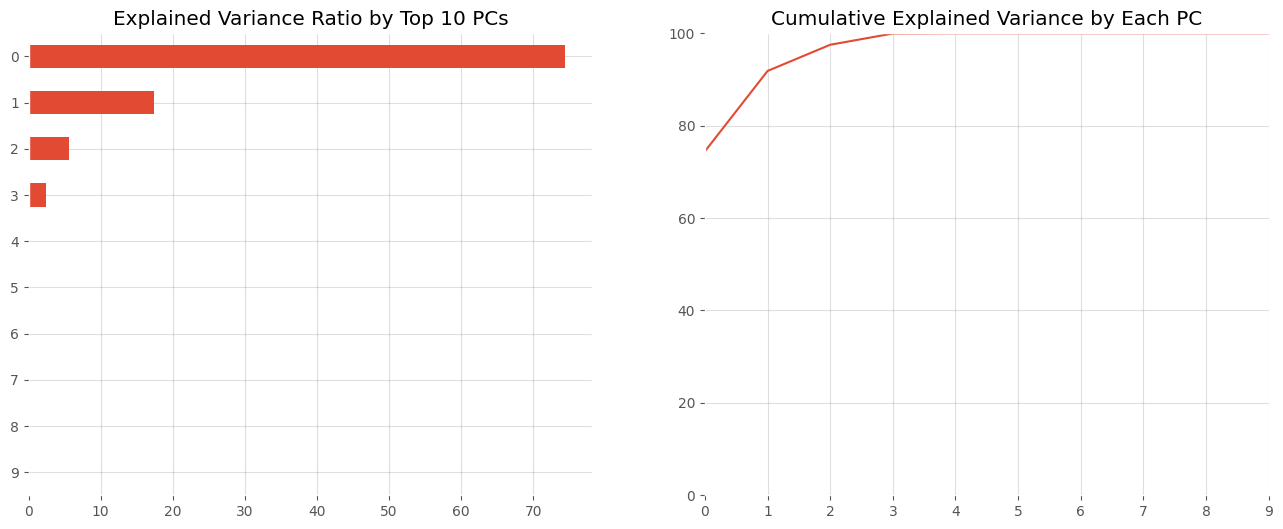

In [31]:
X_full=X.copy()

NumEigenValues = 10

pca = PCA()
PrincipalComponent = pca.fit(X_full)

fig, axes =\
(
    plt
    .subplots(ncols = 2,
              figsize = [16, 6]
             )
)

# Plot on the left panel

Series1 =\
(
    pd
    .Series(pca
            .explained_variance_ratio_[ :NumEigenValues]
           )
    .sort_values()
    * 100
)

# Plot on the right panel

Series2 =\
(
    pd
    .Series(pca
            .explained_variance_ratio_[ :NumEigenValues]
           )
    .cumsum()
    * 100
)

(
    Series1
    .plot
    .barh(ylim = (0, 9),
          title = "Explained Variance Ratio by Top 10 PCs",
          ax = axes[0]
         )
)

(
    Series2
    .plot(ylim = (0, 100),
          xlim = (0, 9),
          title = "Cumulative Explained Variance by Each PC",
          ax = axes[1]
         )
)
plt.show()

#### 2.1.4 Dimensionality Reduction using PCA

In [32]:
# Apply PCA

pca = PCA(n_components=5)  # You can adjust the number of components based on your requirements
X_full_pca = pca.fit_transform(X_full)

# Create a DataFrame with the principal components
columns = [f"PC{i+1}" for i in range(X_full_pca.shape[1])]
df_full_pca = pd.DataFrame(data=X_full_pca, columns=columns,index=X_full.index)

X_full=df_full_pca

### 2.2 Model specification

In [33]:
num_folds = 10
seed = 230926
scoring = "neg_mean_squared_error"

In [34]:
models = []

In [35]:
models.append(("LR", LinearRegression()
             )
            )

models.append(("LASSO", Lasso()
             )
            )

models.append(("EN", ElasticNet()
             )
            )

models.append(("CART", DecisionTreeRegressor()
             )
            )

models.append(("KNN", KNeighborsRegressor()
             )
            )

models.append(("SVR", SVR()
             )
            )

In [36]:
# Bagging (Boostrap Aggregation)

models.append(("RFR", RandomForestRegressor()
              )
             )

models.append(("ETR", ExtraTreesRegressor()
              )
             )

# Boosting

models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor()
              )
             )

In [37]:
# Gift for you

# Team, let me guide you through this step-by-step

### Initialization of Lists:

names = []

kfold_results = []

train_results = []
test_results = []

# Four empty lists are initialized. 
# names will store the names of the models, 
# kfold_results will store the cross-validation results, 
# train_results and test_results 
# will store the performance of the models 
# on the training and testing datasets, respectively.

### Looping through Models:

# Let's iterate over a list of models. 

# Each element in the models list is a tuple 
# containing the name of the model (name) and the model object (model).

for name, model in models:
    
### Appending Model Names:

# The name of the current model is appended to the names list.

    names.append(name)
    
### Let's run K-fold Cross-Validation
    
    kfold =\
        (KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        )
    
# A KFold object is created with a specified number of splits (num_folds), 
# a random seed (seed), 
# and shuffling enabled.
    
### Running Cross-Validation:
# Let's convert MSE to positive (Here, now it becomes lower the better; See below)

    cv_results =\
        (
         -1
         *
         cross_val_score(model, X_full, Y,
                         cv = kfold,
                         scoring = scoring)
        )
        
# Cross-validation is performed on the training data (X_train, Y_train) using the current model. 
# The negative mean squared error is used 
# as the scoring metric 
# (hence multiplied by -1 to make it positive, 
# as the convention is that higher scores are better).

# Storing Cross-Validation Results:
 
### The cross-validation results for the current model are appended to the kfold_results list.    
    
    kfold_results.append(cv_results)

# Fitting the Model on the Entire Training Set:
  
    res = model.fit(X_full, Y) # The model is trained on the entire training dataset.

### Evaluating Model on Training Set:

# The trained model’s predictions on the training set are evaluated 
# using the mean squared error, and the result is appended to train_results.

    train_result = mean_squared_error(res.predict(X_full), Y)
    
    train_results.append(train_result)

## Evaluating Model on Testing Set:    
    
# Similarly, the model’s performance is evaluated 
# on the testing set and appended to test_results.
    
#     test_result = mean_squared_error(res.predict(X_test), Y_test)
    
#     test_results.append(test_result)
    
# Printing the Results:

# The name of the model, 
# the average cross-validation score, 
# the standard deviation of the cross-validation scores, 
# the training set performance, 
# and the testing set performance are printed out.

    message = "%s: %f (%f) %f" % (name, cv_results.mean(), 
                                     cv_results.std(), 
                                     train_result)
    print(message)

LR: 26.175320 (9.230048) 25.503865
LASSO: 26.174961 (9.279149) 25.506547
EN: 26.174268 (9.255280) 25.504580
CART: 49.960548 (11.951896) 0.000000
KNN: 30.545535 (10.174801) 20.595091
SVR: 27.503136 (11.132214) 26.241236
RFR: 28.488738 (7.853919) 3.734608
ETR: 28.281152 (7.566532) 0.000000
GBR: 31.114354 (8.436411) 9.330924
ABR: 33.118869 (10.033086) 22.693148


In [38]:
fig = plt.figure(figsize = [16, 8]
                )

fig.suptitle("Algorithm Comparison: Results of K-Fold Cross Validation")

ax = fig.add_subplot(111)

plt.boxplot(kfold_results)

ax.set_xticklabels(names)

plt.show()

In [39]:
fig = plt.figure(figsize = [16, 8])

ind = np.arange(len(names)
               )

width = 0.30

fig.suptitle("Comparing the Perfomance of Various Algorithms on the Training Data")

ax = fig.add_subplot(111)

(plt
 .bar(ind - width/2,
    
      # Team, this line calculates the starting x position of the bars 
      # representing "Errors in Training Set". 
      # The width/2 term is used to shift the bars to the left, 
      # so they are centered around the tick mark for each group (algorithm) on the x-axis.
      
      # The bar chart will have two sets of bars for each algorithm: 
      # one for training errors and one for testing errors. 
      
      # By subtracting width/2 from ind, 
      # the training error bars are positioned to the left of the center of the tick marks. 
      
      train_results,
      width = width,
      label = "Errors in Training Set")
)

# (plt
#  .bar(ind + width/2,
#       test_results,
#       width = width,
#       label = "Errors in Testing Set")
# )

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error (MSE)")

plt.show()

### 2.3 Result (Full In Sample)

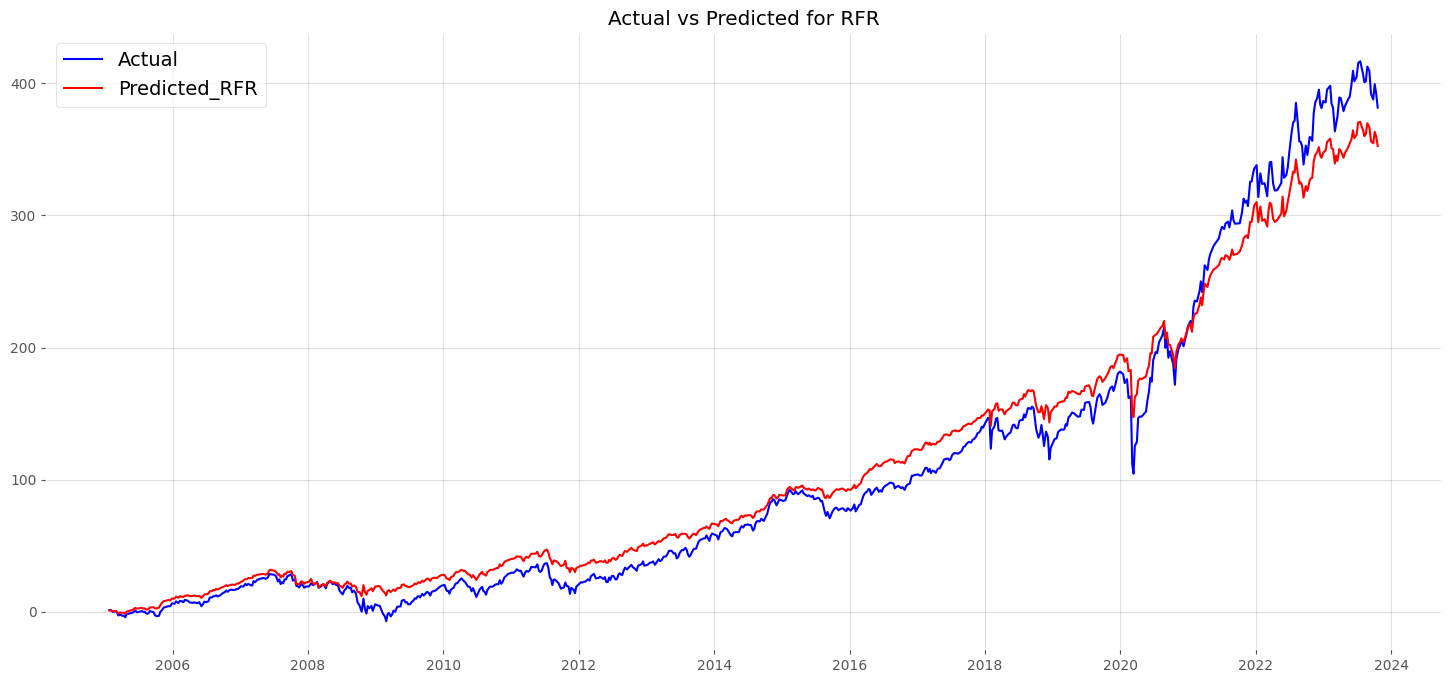

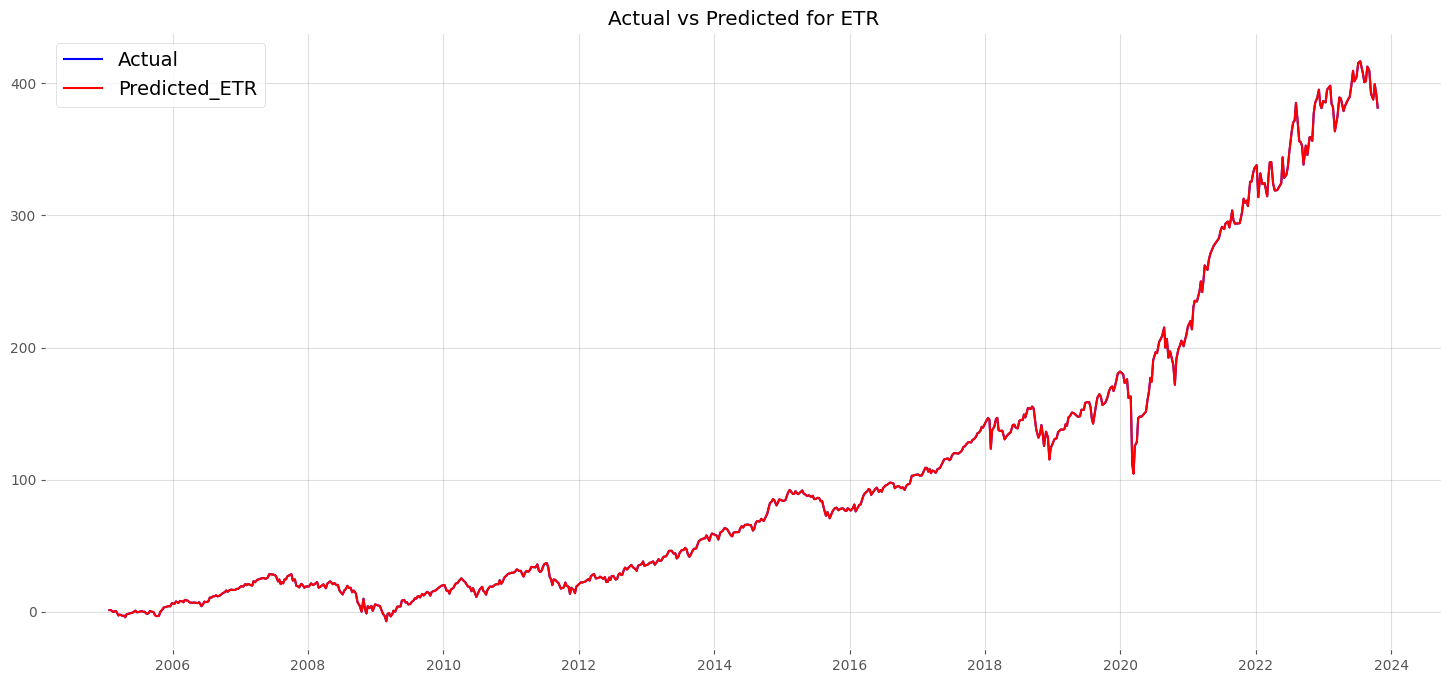

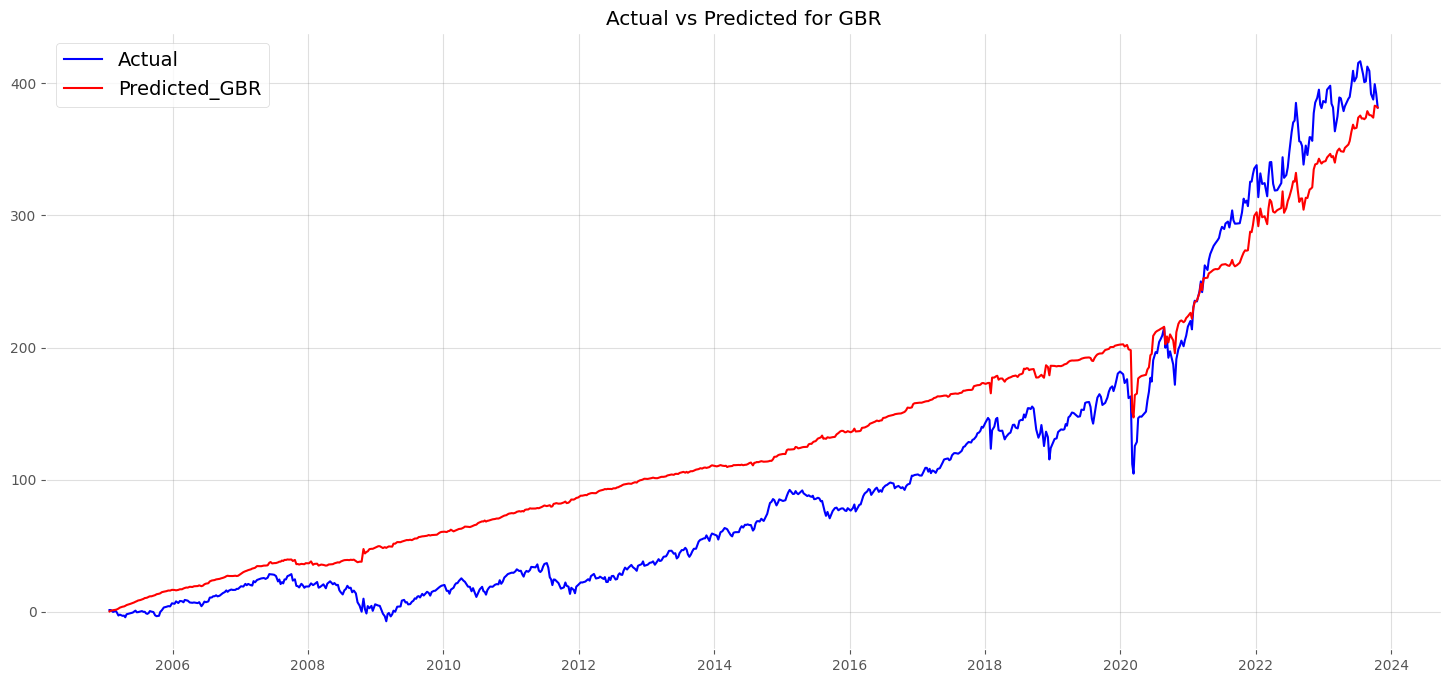

In [40]:
models_to_consider=['CART','RFR','ETR','GBR']
for name,model in models:
    if (name in models_to_consider):
        plt.figure(figsize=[18,8])
        fitted_model = model.fit(X_full, Y)
        predicted_y = model.predict(X_full)
        predicted_y=pd.DataFrame(predicted_y)
        predicted_y.index=Y.index
        plt.plot(Y.cumsum(),color='b',label='Actual')
        plt.plot(predicted_y.cumsum(),color='r',label=f"Predicted_{name}")
        plt.legend()
        plt.title(f"Actual vs Predicted for {name}")
        plt.show()

In [41]:
models_to_consider=['ETR']
for name,model in models:
    if (name in models_to_consider):
        fitted_model = model.fit(X_full, Y)
        predicted_y = model.predict(X_full)
        predicted_y=pd.DataFrame(predicted_y)
        predicted_y.columns=['prediction']
        predicted_y.index=Y.index
        print(name)
        print(np.sign(Y*predicted_y['prediction']).value_counts())
        print(f"Accuracy = {100*(np.sign(Y*predicted_y['prediction']).value_counts()[1]+np.sign(Y*predicted_y['prediction']).value_counts()[0])/np.sign(Y*predicted_y['prediction']).value_counts().sum():.1f}%")

ETR
1.0    723
0.0      2
Name: count, dtype: int64
Accuracy = 100.0%


In [42]:
predicted_y['Position']=np.where(predicted_y['prediction']>0,1,-1)
test_data=(stock_data.loc[ : , ("Adj Close", "SPY")])
test_data.name='Adj Close'
test_data=test_data.to_frame()
final_data=pd.concat([test_data,predicted_y['Position']],axis=1)
#final_data=final_data[final_data.index<=predicted_y.index[-1]]
final_data=final_data.fillna(method='ffill')
final_data=final_data.dropna()

+-----------------------+---------------------+
|             Statistic |               Value |
+-----------------------+---------------------+
| Final Account Balance | $ 19,138,374,549.76 |
|    Cummulative return |        19105681.19% |
|         Strategy CAGR |              91.13% |
|          Max Drawdown |             -12.79% |
|          Sharpe Ratio |               3.487 |
|         Sortino Ratio |               6.864 |
+-----------------------+---------------------+


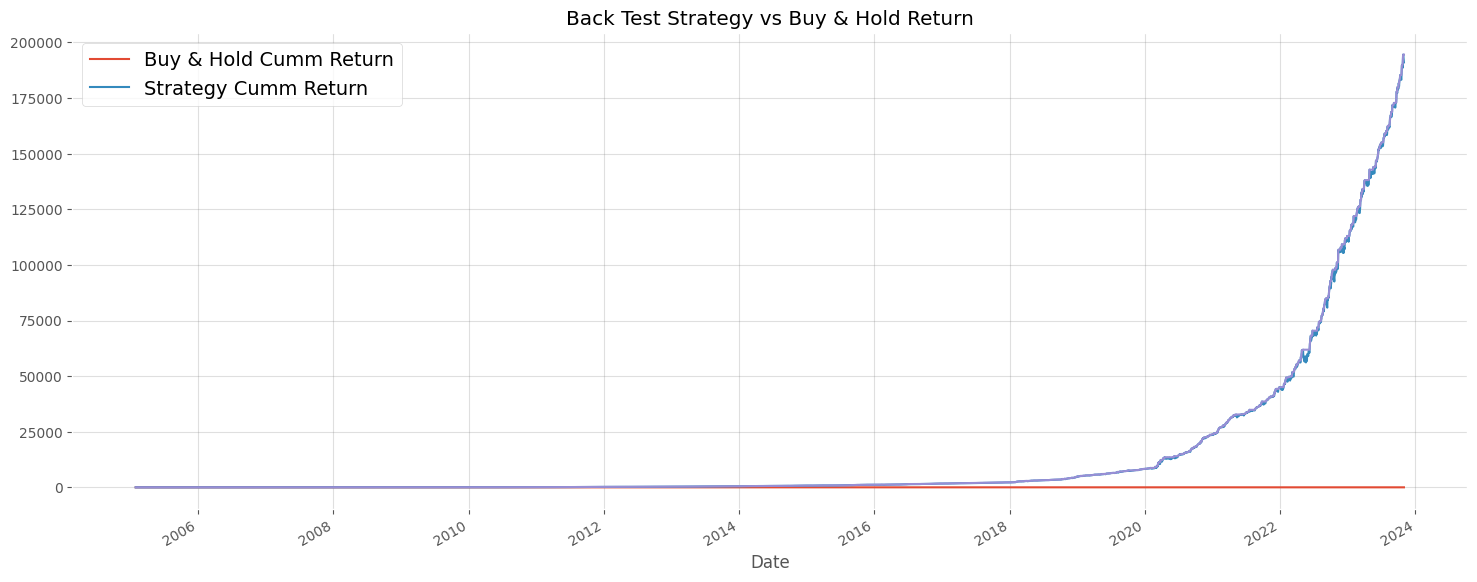

% Return by Quarter:
+------+----------+----------+----------+-----------+
| year |       Q1 |       Q2 |       Q3 |        Q4 |
+------+----------+----------+----------+-----------+
| 2005 |  8.39219 | 13.07731 | 10.83443 |  12.15412 |
| 2006 | 14.11644 |  0.52575 | 10.60669 |    7.7518 |
| 2007 |  7.41892 |  9.21545 | 17.91571 |  27.15912 |
| 2008 |  1.57112 | 28.20016 | 20.52182 | 153.22993 |
| 2009 | 42.28894 | 25.18478 | 23.58574 |  21.81416 |
| 2010 | 21.87916 | 27.38326 | 22.44161 |  13.72257 |
| 2011 | 19.93781 | 18.90995 |  32.1803 |  24.53924 |
| 2012 | 10.67732 | 10.69826 | 14.52551 |  12.76477 |
| 2013 |  6.46743 | 15.41993 | 14.92843 |  14.29196 |
| 2014 | 12.63553 |  9.79073 |  5.65202 |   18.4123 |
| 2015 |  8.33785 |  4.34469 | 20.37787 |   8.33857 |
| 2016 |  6.74566 | 14.03977 |  8.78974 |   10.6184 |
| 2017 |  8.71166 |   4.7024 |  8.18594 |   7.70318 |
| 2018 | 25.20403 | 13.71882 |  9.99955 |   36.8488 |
| 2019 | 16.01881 | 13.58648 | 16.38908 |  12.06388 |
| 2020 

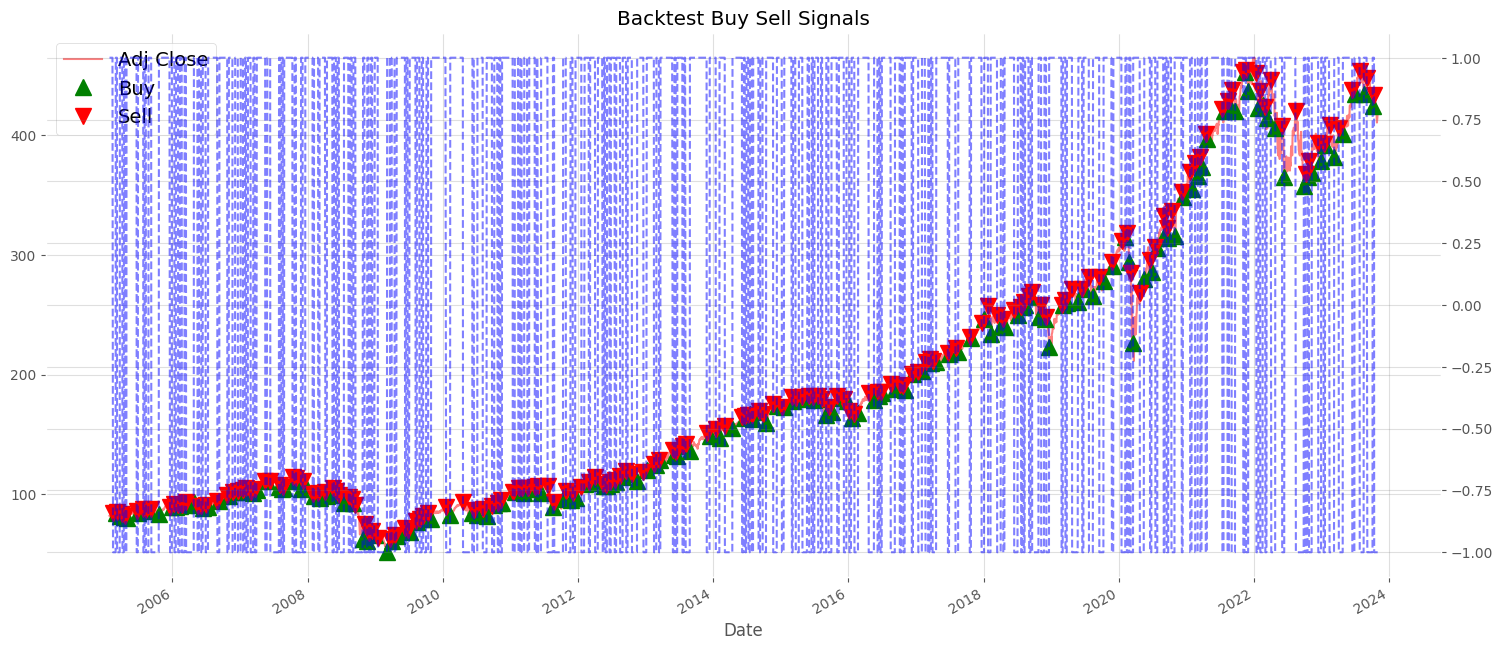

In [43]:
Backtest_ML_Strategy=Backtest(final_data,100000,0)
Backtest_ML_Strategy.plot_all_stats()

## 3. Including Out of Sample Backtesting (Extra Work for Validating the model)

### 3.1 Feature Engineering

#### 3.1.1 Data Split

In [44]:
validation_size = 0.2  ## This is not the conventional validation set -- this is testing set

train_size =\
    int(len(X) 
        * 
        (1 - validation_size)
       )

X_train, X_test =\
    (X[0         :train_size], 
     X[train_size:len(X)    ]
    )

Y_train, Y_test =\
    (Y[0         :train_size], 
     Y[train_size:len(X)    ]
    )

In [45]:
X_train

CL=F      ES=F       IEF      ZB=F      ^VIX      ^GDAXI  \
Date                                                                       
2005-01-26  1.230000 -10.25000  0.006184 -0.031303  0.259999  -31.429688   
2005-02-02 -2.090000  20.00000  0.180099  0.937500 -1.780000   82.189941   
2005-02-14  2.160000   5.50000 -0.024799 -0.250000 -0.209999   20.049805   
2005-03-01  0.529999  25.25000 -0.309891 -0.750000 -1.100000   60.410156   
2005-03-08  2.910000  10.50000 -0.037426  0.281197  0.360000   12.879883   
...              ...       ...       ...       ...       ...         ...   
2019-12-03 -1.910000 -41.75000  0.394646  0.812500  4.090000 -247.129883   
2019-12-11  0.329998  32.00000 -0.169014  0.187500  0.190000    6.169922   
2019-12-18  2.170002  51.75000 -0.976639 -2.843750 -2.410000   75.419922   
2019-12-30  1.240002  -7.52002  0.319710  0.000000  2.309999  -51.970703   
2020-01-16 -1.040001  40.50000  0.357330  1.281250 -0.220000  -65.629883   

                   ^HSI       ^IXIC       ^N225    SPY_DT   SPY_3DT   SPY_6DT  \
Date                                                                            
2005-01-26   -54.950195  -27.500122  -28.769531 -0.008409 -0.013556 -0.021720   
2005-02-02   -67.879883   28.970093   30.569336  0.017252  0.009181 -0.001675   
2005-02-14   222.230469    0.879883  132.339844  0.005068  0.034822 -0.001573   
2005-03-01   -29.369141   40.930054  182.820312  0.021933  0.009615  0.024973   
2005-03-08  -179.440430    2.300049  106.379883  0.009033  0.013580  0.048402   
...                 ...         ...         ...       ...       ...       ...   
2019-12-03  -522.619141 -127.290039    6.490234 -0.012265  0.003884  0.031371   
2019-12-11   582.869141   87.379883  256.628906  0.009459  0.007951  0.036304   
2019-12-18  1238.781250  173.690430  542.570312  0.016309  0.017392  0.040094   
2019-12-30   412.980469    0.339844 -164.490234  0.001091  0.024435  0.041475   
2020-01-16   322.039062  153.700195  193.261719  0.012987  0.029719  0.071661   

            SPY_12DT  
Date                  
2005-01-26  0.039919  
2005-02-02  0.025948  
2005-02-14  0.020919  
2005-03-01  0.020509  
2005-03-08  0.030548  
...              ...  
2019-12-03  0.041962  
2019-12-11  0.048493  
2019-12-18  0.077119  
2019-12-30  0.105267  
2020-01-16  0.103032  

[580 rows x 13 columns]

#### 3.1.2 Add Polynomial Features to capture non-linear relationships

In [46]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree=3)
# X_train_poly = poly.fit_transform(X_train)

# columns = [f"Feature{i+1}" for i in range(X_train_poly.shape[1])]
# df_train_poly = pd.DataFrame(data=X_train_poly, columns=columns,index=X_train.index)

# X_train=df_train_poly

# X_test_poly = poly.transform(X_test)

# columns = [f"Feature{i+1}" for i in range(X_test_poly.shape[1])]
# df_test_poly = pd.DataFrame(data=X_test_poly, columns=columns,index=X_test.index)

# X_test=df_test_poly

In [47]:
X_train

CL=F      ES=F       IEF      ZB=F      ^VIX      ^GDAXI  \
Date                                                                       
2005-01-26  1.230000 -10.25000  0.006184 -0.031303  0.259999  -31.429688   
2005-02-02 -2.090000  20.00000  0.180099  0.937500 -1.780000   82.189941   
2005-02-14  2.160000   5.50000 -0.024799 -0.250000 -0.209999   20.049805   
2005-03-01  0.529999  25.25000 -0.309891 -0.750000 -1.100000   60.410156   
2005-03-08  2.910000  10.50000 -0.037426  0.281197  0.360000   12.879883   
...              ...       ...       ...       ...       ...         ...   
2019-12-03 -1.910000 -41.75000  0.394646  0.812500  4.090000 -247.129883   
2019-12-11  0.329998  32.00000 -0.169014  0.187500  0.190000    6.169922   
2019-12-18  2.170002  51.75000 -0.976639 -2.843750 -2.410000   75.419922   
2019-12-30  1.240002  -7.52002  0.319710  0.000000  2.309999  -51.970703   
2020-01-16 -1.040001  40.50000  0.357330  1.281250 -0.220000  -65.629883   

                   ^HSI       ^IXIC       ^N225    SPY_DT   SPY_3DT   SPY_6DT  \
Date                                                                            
2005-01-26   -54.950195  -27.500122  -28.769531 -0.008409 -0.013556 -0.021720   
2005-02-02   -67.879883   28.970093   30.569336  0.017252  0.009181 -0.001675   
2005-02-14   222.230469    0.879883  132.339844  0.005068  0.034822 -0.001573   
2005-03-01   -29.369141   40.930054  182.820312  0.021933  0.009615  0.024973   
2005-03-08  -179.440430    2.300049  106.379883  0.009033  0.013580  0.048402   
...                 ...         ...         ...       ...       ...       ...   
2019-12-03  -522.619141 -127.290039    6.490234 -0.012265  0.003884  0.031371   
2019-12-11   582.869141   87.379883  256.628906  0.009459  0.007951  0.036304   
2019-12-18  1238.781250  173.690430  542.570312  0.016309  0.017392  0.040094   
2019-12-30   412.980469    0.339844 -164.490234  0.001091  0.024435  0.041475   
2020-01-16   322.039062  153.700195  193.261719  0.012987  0.029719  0.071661   

            SPY_12DT  
Date                  
2005-01-26  0.039919  
2005-02-02  0.025948  
2005-02-14  0.020919  
2005-03-01  0.020509  
2005-03-08  0.030548  
...              ...  
2019-12-03  0.041962  
2019-12-11  0.048493  
2019-12-18  0.077119  
2019-12-30  0.105267  
2020-01-16  0.103032  

[580 rows x 13 columns]

#### 3.1.3 PCA check

<Axes: title={'center': 'Cumulative Explained Variance by Each PC'}>

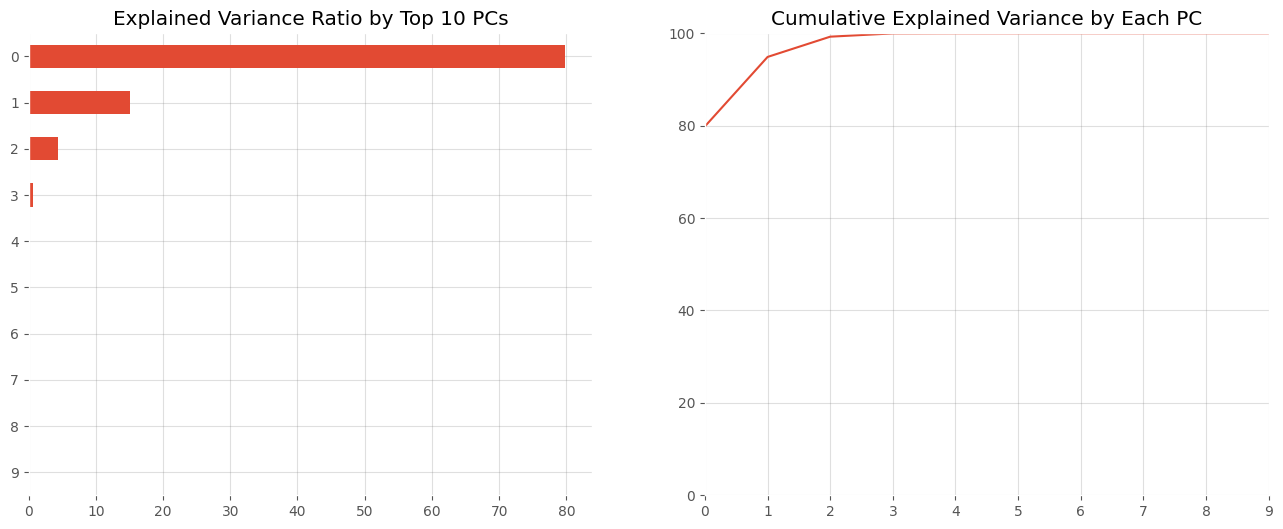

In [48]:
NumEigenValues = 10

pca = PCA()
PrincipalComponent = pca.fit(X_train)

fig, axes =\
(
    plt
    .subplots(ncols = 2,
              figsize = [16, 6]
             )
)

# Plot on the left panel

Series1 =\
(
    pd
    .Series(pca
            .explained_variance_ratio_[ :NumEigenValues]
           )
    .sort_values()
    * 100
)

# Plot on the right panel

Series2 =\
(
    pd
    .Series(pca
            .explained_variance_ratio_[ :NumEigenValues]
           )
    .cumsum()
    * 100
)

(
    Series1
    .plot
    .barh(ylim = (0, 9),
          title = "Explained Variance Ratio by Top 10 PCs",
          ax = axes[0]
         )
)

(
    Series2
    .plot(ylim = (0, 100),
          xlim = (0, 9),
          title = "Cumulative Explained Variance by Each PC",
          ax = axes[1]
         )
)

In [49]:
pca.explained_variance_ratio_

array([7.986e-01, 1.502e-01, 4.387e-02, 7.047e-03, 2.748e-04, 1.384e-05,
       5.629e-06, 5.438e-06, 1.288e-07, 1.001e-08, 1.913e-09, 6.346e-10,
       1.027e-10])

#### 3.1.4 Dimension reduction using PCA

In [50]:
# Apply PCA

pca = PCA(n_components=5)  # You can adjust the number of components based on your requirements
X_train_pca = pca.fit_transform(X_train)

# Create a DataFrame with the principal components
columns = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]
df_train_pca = pd.DataFrame(data=X_train_pca, columns=columns,index=X_train.index)

X_train=df_train_pca

X_test_pca = pca.transform(X_test)

# Create a DataFrame with the principal components
columns = [f"PC{i+1}" for i in range(X_test_pca.shape[1])]
df_test_pca = pd.DataFrame(data=X_test_pca, columns=columns,index=X_test.index)

X_test=df_test_pca

# # Print the DataFrame with principal components
# print("DataFrame with Principal Components:")
# print(df_pca.head())

# # Get the feature importances (loadings) from PCA
# feature_importances = pca.components_

# # Create a DataFrame with feature importances
# df_feature_importances = pd.DataFrame(data=feature_importances, columns=X.columns, index=columns)

# # Print the DataFrame with feature importances
# print("\nDataFrame with Feature Importances:")
# print(df_feature_importances)

In [51]:
pca.explained_variance_ratio_

array([7.986e-01, 1.502e-01, 4.387e-02, 7.047e-03, 2.748e-04])

### 3.2 Model Specification

In [52]:
num_folds = 10
seed = 230926
scoring = "neg_mean_squared_error"

In [53]:
models = []

In [54]:
models.append(("LR", LinearRegression()
             )
            )

models.append(("LASSO", Lasso()
             )
            )

models.append(("EN", ElasticNet()
             )
            )

models.append(("CART", DecisionTreeRegressor()
             )
            )

models.append(("KNN", KNeighborsRegressor()
             )
            )

models.append(("SVR", SVR()
             )
            )

In [55]:
# Bagging (Boostrap Aggregation)

models.append(("RFR", RandomForestRegressor()
              )
             )

models.append(("ETR", ExtraTreesRegressor()
              )
             )

# Boosting

models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor()
              )
             )

In [56]:
### Initialization of Lists:

names = []

kfold_results = []

train_results = []
test_results = []

# Four empty lists are initialized. 
# names will store the names of the models, 
# kfold_results will store the cross-validation results, 
# train_results and test_results 
# will store the performance of the models 
# on the training and testing datasets, respectively.

### Looping through Models:

# Let's iterate over a list of models. 

# Each element in the models list is a tuple 
# containing the name of the model (name) and the model object (model).

for name, model in models:
    
### Appending Model Names:

# The name of the current model is appended to the names list.

    names.append(name)
    
### Let's run K-fold Cross-Validation
    
    kfold =\
        (KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        )
    
# A KFold object is created with a specified number of splits (num_folds), 
# a random seed (seed), 
# and shuffling enabled.
    
### Running Cross-Validation:
# Let's convert MSE to positive (Here, now it becomes lower the better; See below)

    cv_results =\
        (
         -1
         *
         cross_val_score(model, X_train, Y_train,
                         cv = kfold,
                         scoring = scoring)
        )
        
# Cross-validation is performed on the training data (X_train, Y_train) using the current model. 
# The negative mean squared error is used 
# as the scoring metric 
# (hence multiplied by -1 to make it positive, 
# as the convention is that higher scores are better).

# Storing Cross-Validation Results:
 
### The cross-validation results for the current model are appended to the kfold_results list.    
    
    kfold_results.append(cv_results)

# Fitting the Model on the Entire Training Set:
  
    res = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

### Evaluating Model on Training Set:

# The trained model’s predictions on the training set are evaluated 
# using the mean squared error, and the result is appended to train_results.

    train_result = mean_squared_error(res.predict(X_train), Y_train)
    
    train_results.append(train_result)

## Evaluating Model on Testing Set:    
    
# Similarly, the model’s performance is evaluated 
# on the testing set and appended to test_results.
    
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    
    test_results.append(test_result)
    
# Printing the Results:

# The name of the model, 
# the average cross-validation score, 
# the standard deviation of the cross-validation scores, 
# the training set performance, 
# and the testing set performance are printed out.

    message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
                                     cv_results.std(), 
                                     train_result, 
                                     test_result)
    print(message)

LR: 9.037601 (4.328881) 8.502331 96.182229
LASSO: 9.023303 (4.308764) 8.508199 96.479407
EN: 9.028546 (4.318035) 8.503843 96.322956
CART: 19.964024 (5.305483) 0.000000 121.357295
KNN: 10.567055 (5.183454) 6.860611 104.434879
SVR: 9.153478 (4.342620) 8.490034 100.987942
RFR: 10.047637 (4.105096) 1.417364 99.899964
ETR: 9.946057 (4.345121) 0.000000 96.816233
GBR: 9.892580 (4.459834) 3.534342 103.789432
ABR: 9.466138 (4.118075) 6.105318 100.685019


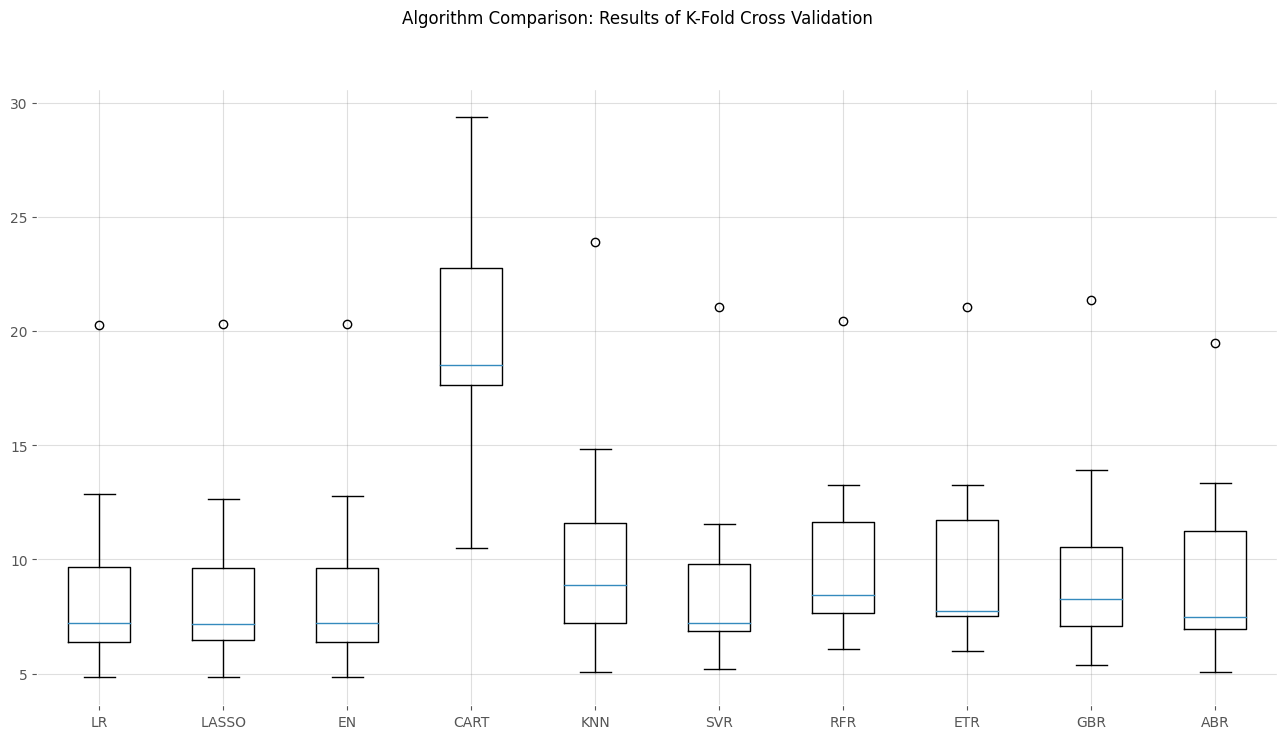

In [57]:
fig = plt.figure(figsize = [16, 8]
                )

fig.suptitle("Algorithm Comparison: Results of K-Fold Cross Validation")

ax = fig.add_subplot(111)

plt.boxplot(kfold_results)

ax.set_xticklabels(names)

plt.show()

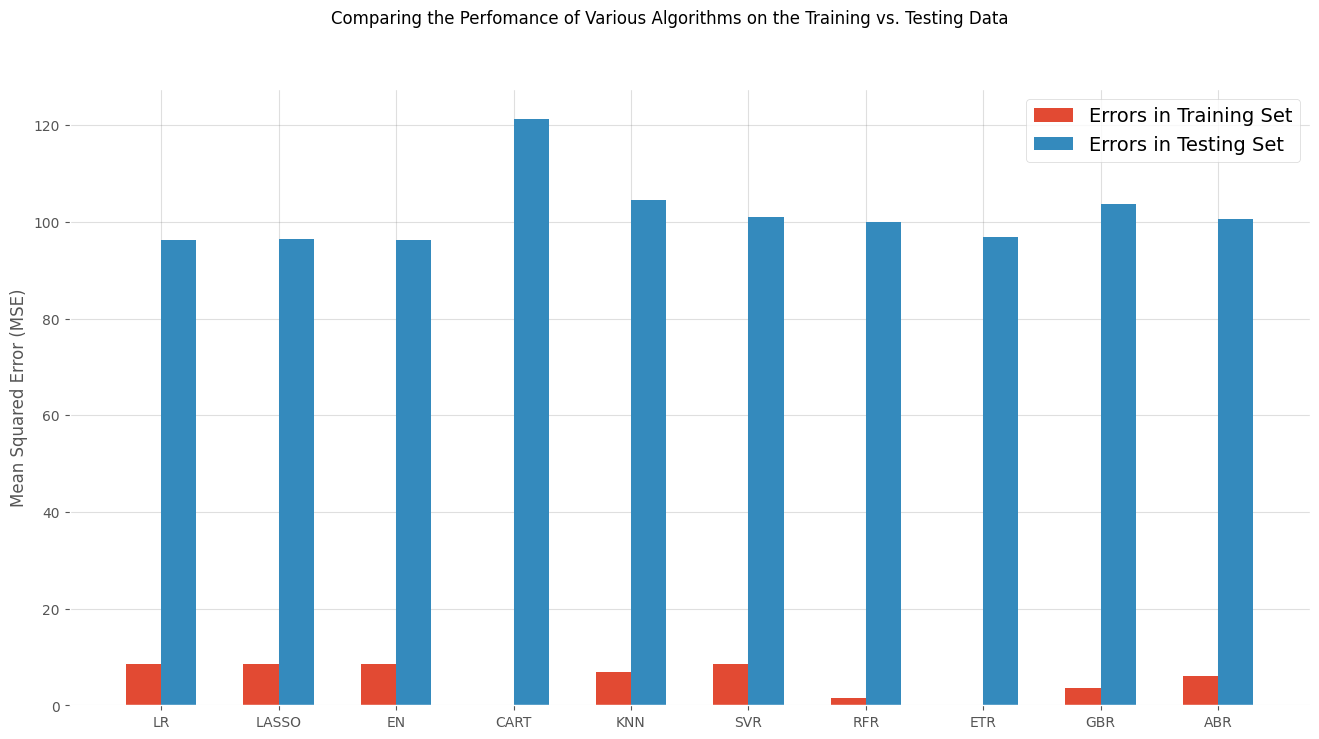

In [58]:
fig = plt.figure(figsize = [16, 8])

ind = np.arange(len(names)
               )

width = 0.30

fig.suptitle("Comparing the Perfomance of Various Algorithms on the Training vs. Testing Data")

ax = fig.add_subplot(111)

(plt
 .bar(ind - width/2,
    
      # Team, this line calculates the starting x position of the bars 
      # representing "Errors in Training Set". 
      # The width/2 term is used to shift the bars to the left, 
      # so they are centered around the tick mark for each group (algorithm) on the x-axis.
      
      # The bar chart will have two sets of bars for each algorithm: 
      # one for training errors and one for testing errors. 
      
      # By subtracting width/2 from ind, 
      # the training error bars are positioned to the left of the center of the tick marks. 
      
      train_results,
      width = width,
      label = "Errors in Training Set")
)

(plt
 .bar(ind + width/2,
      test_results,
      width = width,
      label = "Errors in Testing Set")
)

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error (MSE)")

plt.show()

### 3.3 Results

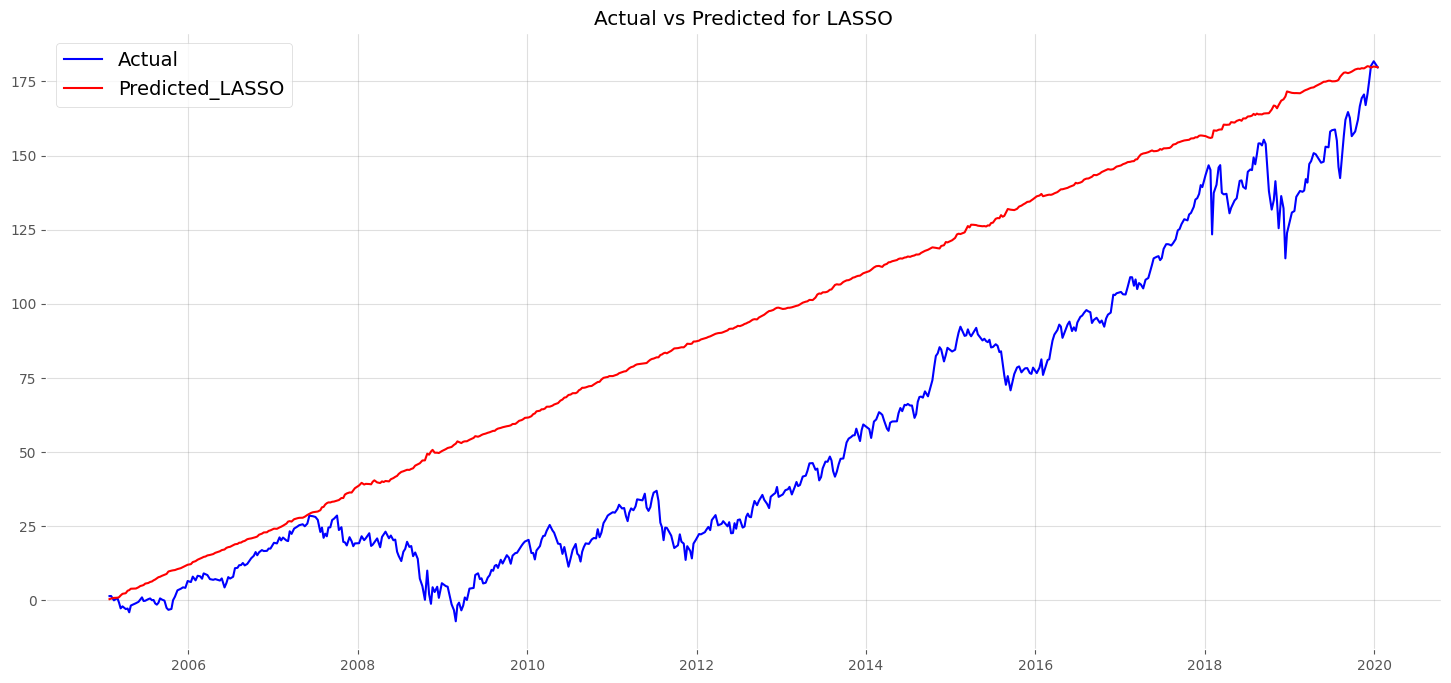

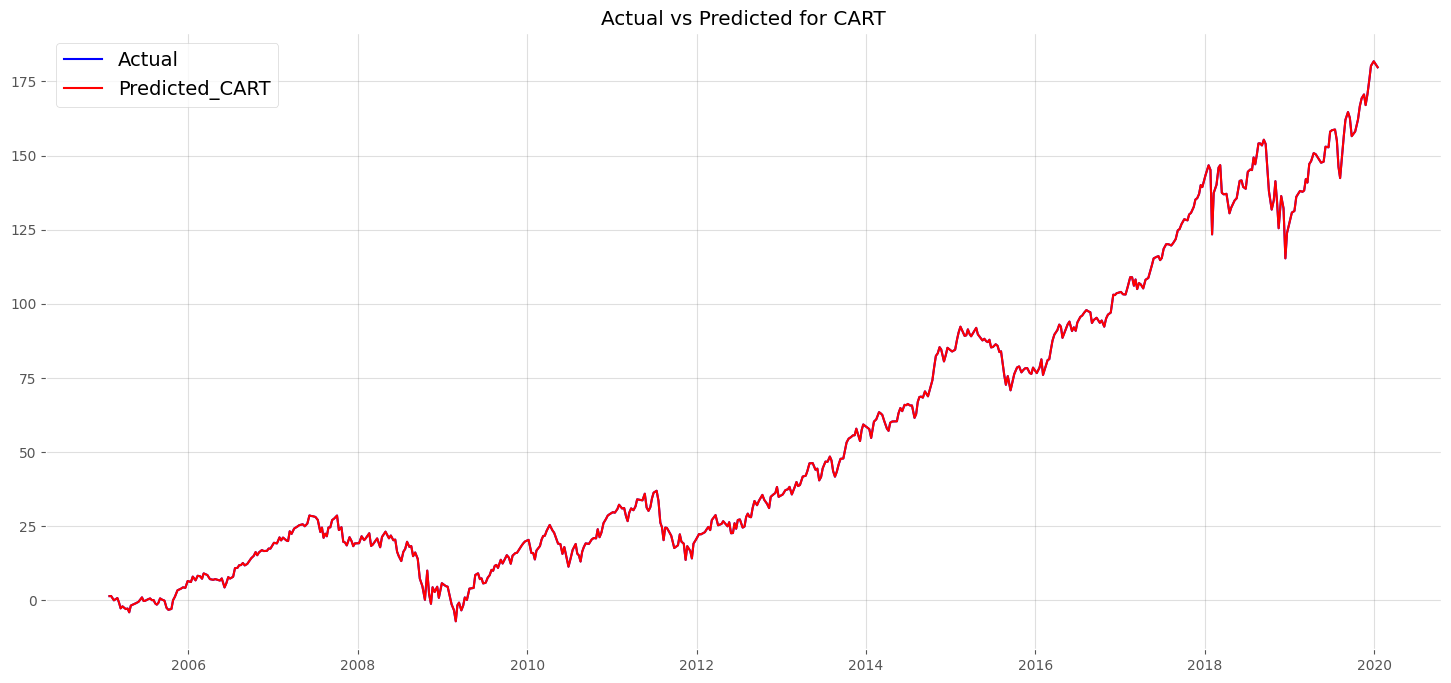

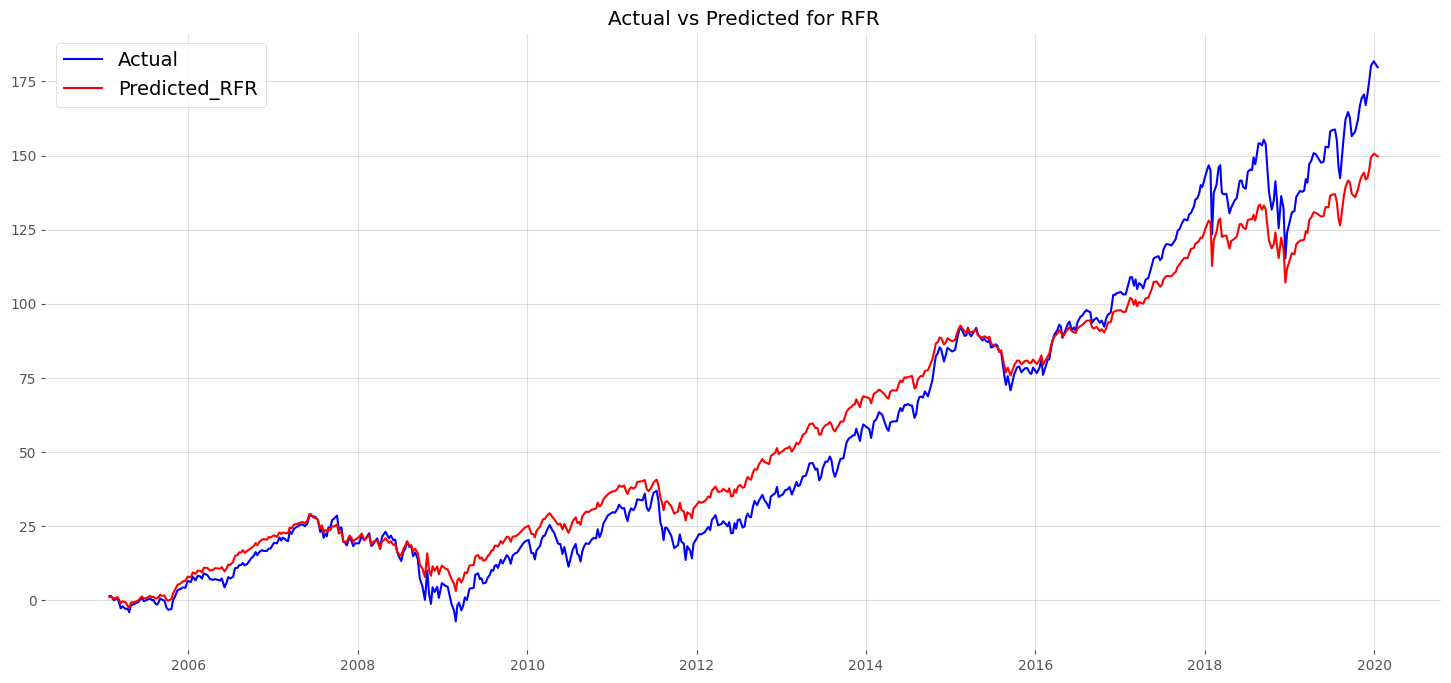

In [59]:
models_to_consider=['CART','LASSO','RFR']
for name,model in models:
    if (name in models_to_consider):
        plt.figure(figsize=[18,8])
        fitted_model = model.fit(X_train, Y_train)
        predicted_y = model.predict(X_train)
        predicted_y=pd.DataFrame(predicted_y)
        predicted_y.index=Y_train.index
        plt.plot(Y_train.cumsum(),color='b',label='Actual')
        plt.plot(predicted_y.cumsum(),color='r',label=f"Predicted_{name}")
        plt.legend()
        plt.title(f"Actual vs Predicted for {name}")
        plt.show()

### 3.3.1 Result In Sample

In [60]:
models_to_consider=['CART']
for name,model in models:
    if (name in models_to_consider):
        fitted_model = model.fit(X_train, Y_train)
        predicted_y = model.predict(X_train)
        predicted_y=pd.DataFrame(predicted_y)
        predicted_y.columns=['prediction']
        predicted_y.index=Y_train.index
        print(name)
        print(np.sign(Y_train*predicted_y['prediction']).value_counts())

CART
1.0    578
0.0      2
Name: count, dtype: int64


In [61]:
predicted_y['Position']=np.where(predicted_y['prediction']>0,1,-1)
test_data=(stock_data.loc[ : , ("Adj Close", "SPY")])
test_data.name='Adj Close'
test_data=test_data.to_frame()
final_data=pd.concat([test_data,predicted_y['Position']],axis=1)
final_data=final_data[final_data.index<=predicted_y.index[-1]]
final_data=final_data.fillna(method='ffill')
final_data=final_data.dropna()

+-----------------------+------------------+
|             Statistic |            Value |
+-----------------------+------------------+
| Final Account Balance | $ 851,039,037.05 |
|    Cummulative return |       849489.69% |
|         Strategy CAGR |           82.93% |
|          Max Drawdown |          -12.79% |
|          Sharpe Ratio |            3.439 |
|         Sortino Ratio |            6.718 |
+-----------------------+------------------+


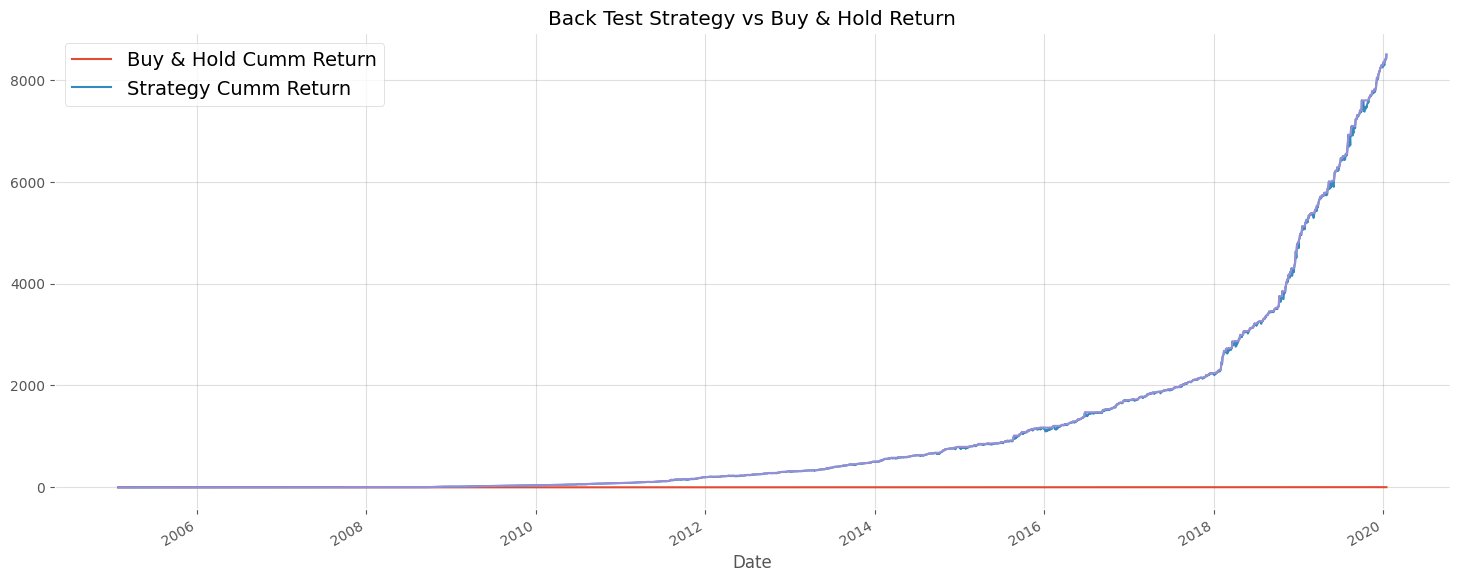

% Return by Quarter:
+------+----------+----------+----------+-----------+
| year |       Q1 |       Q2 |       Q3 |        Q4 |
+------+----------+----------+----------+-----------+
| 2005 |  8.39219 | 13.07731 | 10.83443 |  12.15412 |
| 2006 | 14.11644 |  0.52575 | 10.60669 |    7.7518 |
| 2007 |  7.41892 |  9.21545 | 17.91571 |  27.15912 |
| 2008 |  1.57112 | 28.20016 | 20.52182 | 153.22993 |
| 2009 | 42.28894 | 25.18478 | 23.58574 |  21.81416 |
| 2010 | 21.87916 | 27.38326 | 22.44161 |  13.72257 |
| 2011 | 19.93781 | 18.90995 |  32.1803 |  24.53924 |
| 2012 | 10.67732 | 10.69826 | 14.52551 |  12.76477 |
| 2013 |  6.46743 | 15.41993 | 14.92843 |  14.29196 |
| 2014 | 12.63553 |  9.79073 |  5.65202 |   18.4123 |
| 2015 |  8.33785 |  4.34469 | 20.37787 |   8.33857 |
| 2016 |  6.74566 | 14.03977 |  8.78974 |   10.6184 |
| 2017 |  8.71166 |   4.7024 |  8.18594 |   7.70318 |
| 2018 | 25.20403 | 13.71882 |  9.99955 |   36.8488 |
| 2019 | 16.01881 | 13.58648 | 16.38908 |  12.06388 |
| 2020 

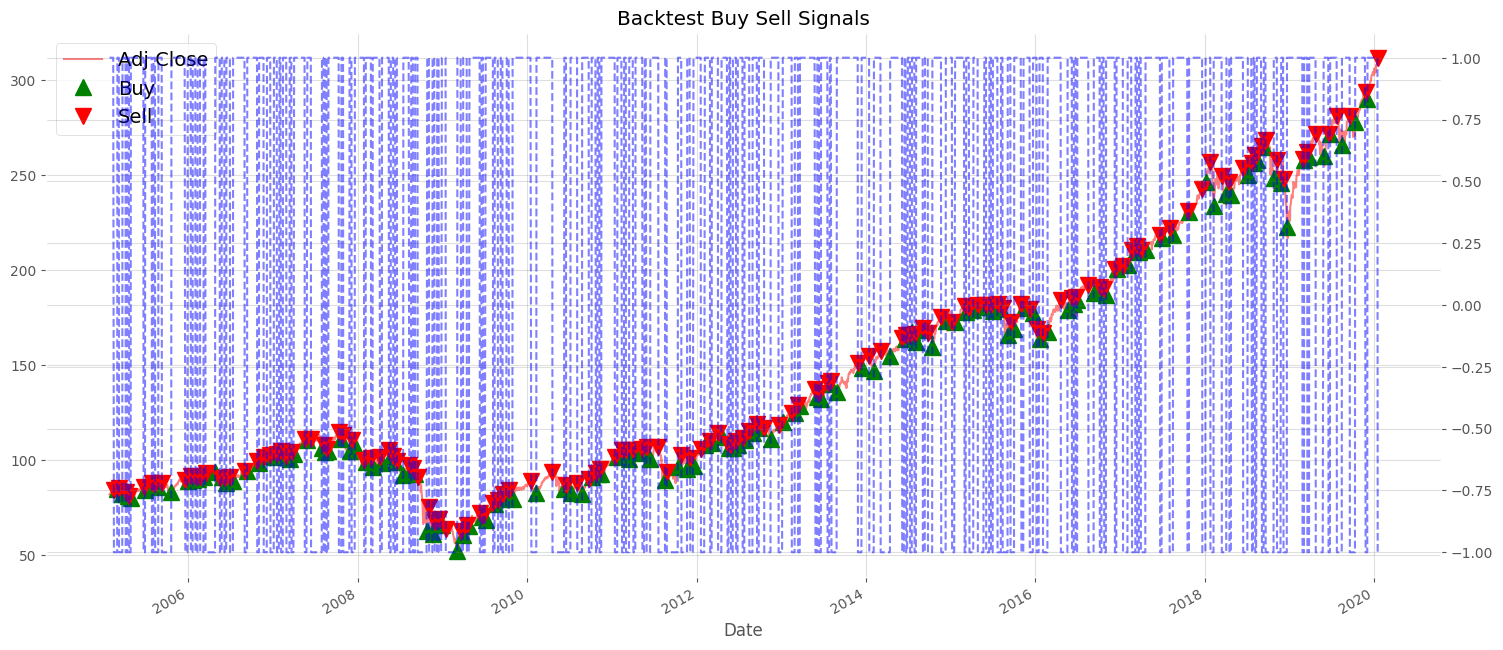

In [62]:
Backtest_ML_Strategy=Backtest(final_data,100000,0)
Backtest_ML_Strategy.plot_all_stats()

## 3.3.2 Result Out of Sample

In [63]:
models_to_consider=['LASSO']
for name,model in models:
    if (name in models_to_consider):
        fitted_model = model.fit(X_train, Y_train)
        predicted_y = model.predict(X_test)
        predicted_y=pd.DataFrame(predicted_y)
        predicted_y.columns=['prediction']
        predicted_y.index=Y_test.index
        print(name)
        print(np.sign(Y_test*predicted_y['prediction']).value_counts())

LASSO
 1.0    86
-1.0    59
Name: count, dtype: int64


In [64]:
predicted_y['Position']=np.where(predicted_y['prediction']>0,1,-1)
test_data=(stock_data.loc[ : , ("Adj Close", "SPY")])
test_data.name='Adj Close'
test_data=test_data.to_frame()
final_data=pd.concat([test_data,predicted_y['Position']],axis=1)
final_data=final_data.fillna(method='ffill')
final_data=final_data.dropna()

+-----------------------+--------------+
|             Statistic |        Value |
+-----------------------+--------------+
| Final Account Balance | $ 230,508.81 |
|    Cummulative return |      134.26% |
|         Strategy CAGR |       25.33% |
|          Max Drawdown |      -20.28% |
|          Sharpe Ratio |        1.088 |
|         Sortino Ratio |        1.876 |
+-----------------------+--------------+


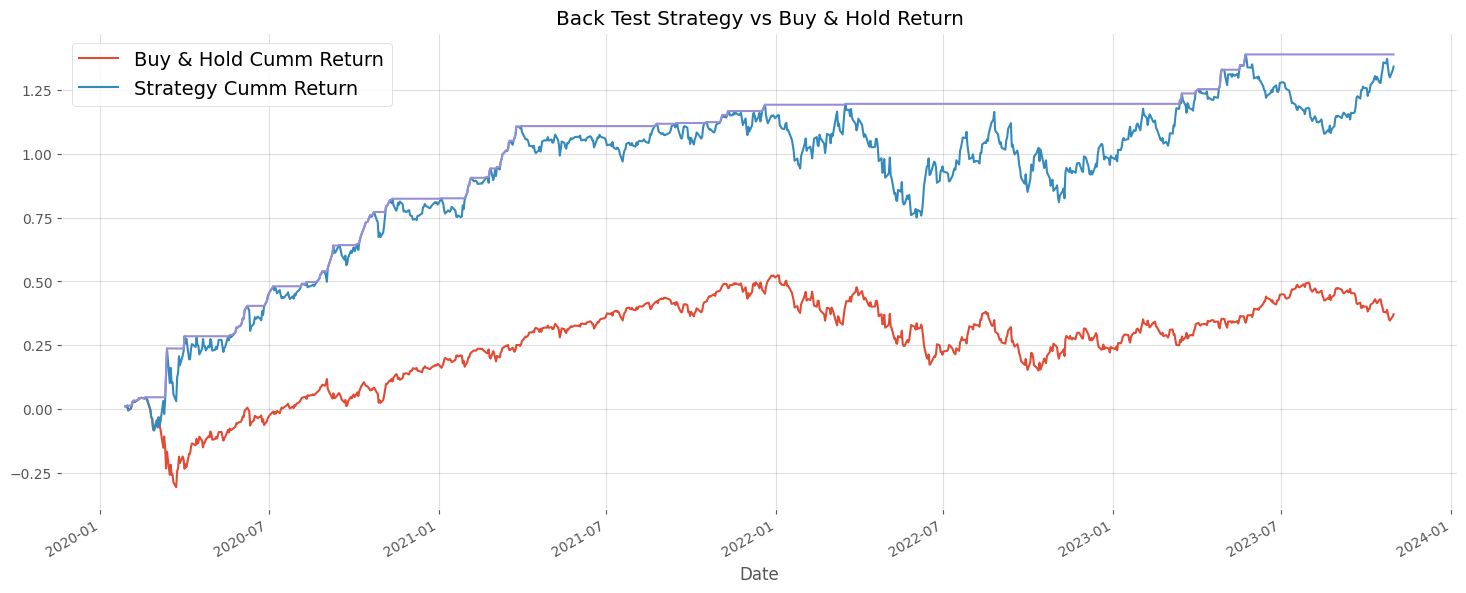

% Return by Quarter:
+------+----------+----------+----------+----------+
| year |       Q1 |       Q2 |       Q3 |       Q4 |
+------+----------+----------+----------+----------+
| 2020 | 22.73325 | 17.35051 | 12.72547 | 10.94818 |
| 2021 | 17.10353 | -2.28306 | -1.06592 |  4.94769 |
| 2022 | -0.07239 | -8.76103 | -5.13469 |  7.36052 |
| 2023 | 13.00883 |  1.48058 | -0.88641 |  3.70767 |
+------+----------+----------+----------+----------+


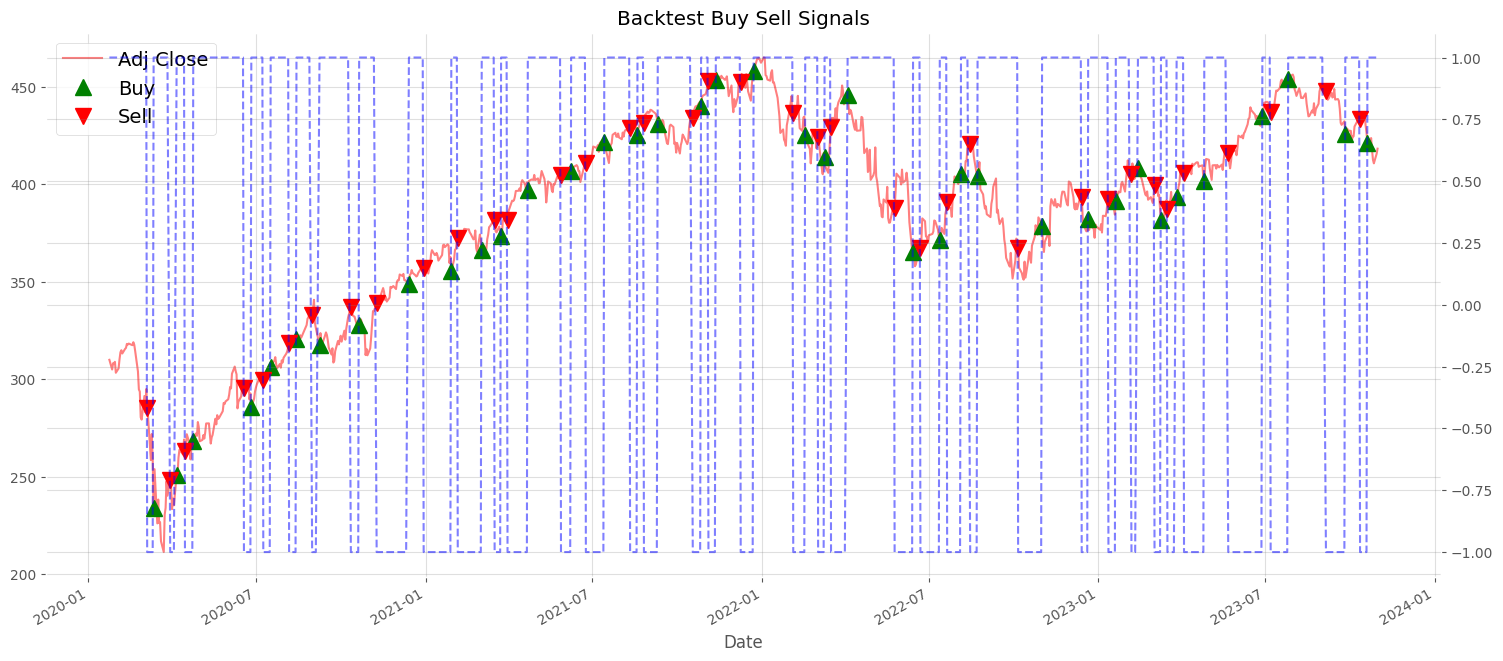

In [65]:
Backtest_ML_Strategy=Backtest(final_data,100000,0)
Backtest_ML_Strategy.plot_all_stats()

### ~Strategy 2 Ends

<a id='strategy_3'></a>

# Strategy 3: 

## Results without hyperparameter tuning

In [24]:
#using the features engineered from Strategy 1
#Group 6 has actually attempted PCA on the exogenous variables but results were inferior. 
#Therefore, we stuck to polynomial features engineering with the original features

Linear regression has intercept of 0.560 and coefficients of [-2.076e+01  5.206e+02  8.927e+02 -1.516e+01  9.686e+00 -5.004e+01
 -9.355e+01 -4.318e-01  1.208e+00  2.609e+00]
 
Logistic regression has intercept of 3.896 and coefficients of [ 0.005  0.005  0.004 -0.013  0.053  0.048  0.044  0.134  0.1    0.133]
 
Accuracy of model is : 0.568
 
Precision of model is : 0.559
 
Recall of model is : 0.999
 


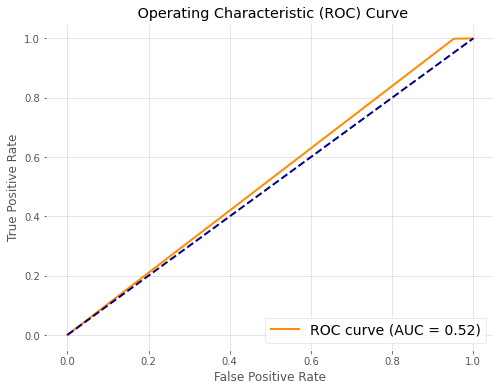

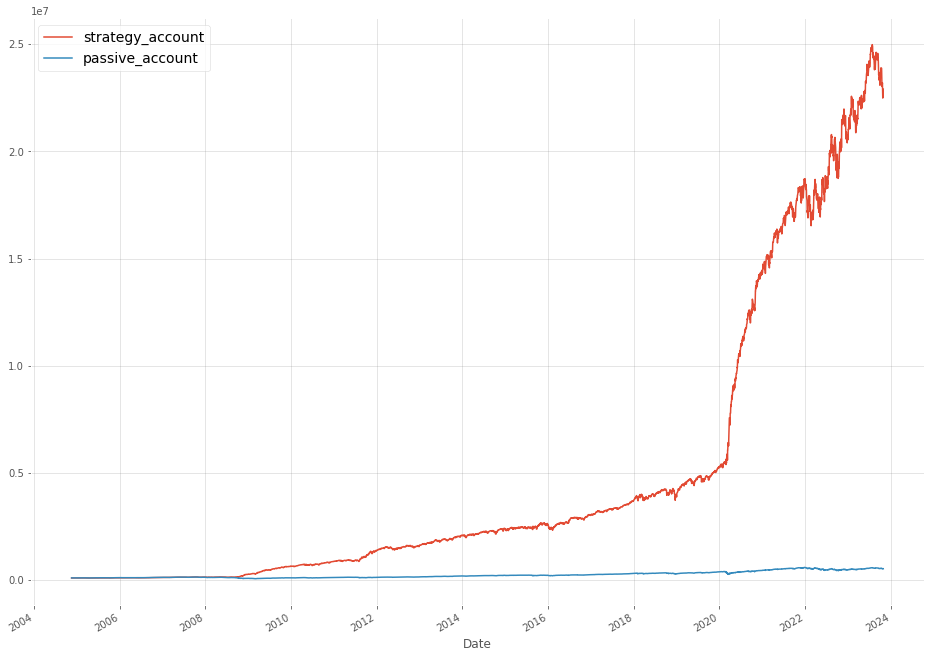

In [29]:
LR = LinearRegression()
LR.fit(X_selected_df, Y_traintest_binary)

print("=================================================================================")

print("Linear regression has intercept of {:.3f} and coefficients of {}".format(LR.intercept_, LR.coef_))
print(" ")

#linear regression
LR_pred_train = LR.predict(X_selected_df)
LR_pred_train_df = pd.DataFrame(LR_pred_train, columns = ['predicted'], index = index_)

#turn all linear regression predictions into binary response of 1 or 0
Y_pred_binary = (LR_pred_train_df > 0).astype(int)

#logistic regression
logreg_sk = LogisticRegression(penalty='elasticnet', l1_ratio=0, solver='saga')
logreg_sk.fit(X_selected_df, Y_pred_binary)

print("Logistic regression has intercept of {:.3f} and coefficients of {}".format(logreg_sk.intercept_[0], logreg_sk.coef_[0]))
print(" ")

Y_pred_logistic = logreg_sk.predict(X_selected_df)
Y_pred_logistic_df = pd.DataFrame(Y_pred_logistic, columns=['predicted'], index = index_)

print("=================================================================================")

print("Accuracy of model is : {:.3f}".format(metrics.accuracy_score(Y_traintest_binary,Y_pred_logistic_df)))
print(" ")
print("Precision of model is : {:.3f}".format(metrics.precision_score(Y_traintest_binary,Y_pred_logistic_df)))
print(" ")
print("Recall of model is : {:.3f}".format(metrics.recall_score(Y_traintest_binary,Y_pred_logistic_df)))
print(" ")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_traintest_binary, Y_pred_logistic)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("=================================================================================")

X_traintest1 = X.copy()
X_traintest1["signal"] =  Y_pred_logistic_df
X_traintest1 = X_traintest1.loc[pd.to_datetime('2004-11-17'):]
X_traintest1 = X_traintest1.ffill()

X_traintest1['strategy_return'] = X_traintest1["signal"] * Y
capital = 100000
X_traintest1['strategy_account'] = X_traintest1['strategy_return'].cumsum().apply(np.exp) * capital
X_traintest1['passive_account'] = Y.cumsum().apply(np.exp) * capital


fig, ax1 = plt.subplots(figsize = [16,12])
X_traintest1['strategy_account'].plot(ax=ax1, label='strategy_account')
X_traintest1['passive_account'].plot(ax=ax1, label='passive_account')
ax1.legend()

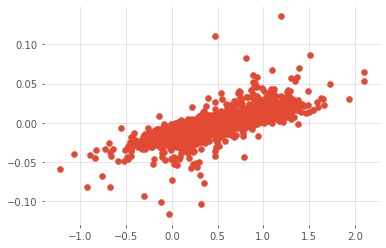

In [30]:
plt.scatter(LR_pred_train, Y_traintest)

# positive linear relationship predictions are close to actual values

+-----------------------+-----------------+
|             Statistic |           Value |
+-----------------------+-----------------+
| Final Account Balance | $ 22,899,030.64 |
|    Cummulative return |       22799.03% |
|         Strategy CAGR |          33.09% |
|          Max Drawdown |         -13.62% |
|          Sharpe Ratio |           1.803 |
|         Sortino Ratio |           3.440 |
+-----------------------+-----------------+


% Return by Quarter:
+------+----------+----------+----------+----------+
| year |       Q1 |       Q2 |       Q3 |       Q4 |
+------+----------+----------+----------+----------+
| 2004 |      nan |      nan |      nan |  2.41271 |
| 2005 | -2.02423 |  1.44206 |  3.67826 |  1.73116 |
| 2006 |  4.68742 | -1.53081 |  5.41129 |  6.60955 |
| 2007 |  4.75761 |  6.39319 |  5.02266 |  1.11904 |
| 2008 |  -4.5141 |  0.67243 | 11.04174 | 75.50811 |
| 2009 | 27.11906 | 37.42644 | 18.29176 | 12.05493 |
| 2010 | 11.25933 | -3.51356 | 14.29406 | 10.76085 |
| 2011 |  5.89738 |  0.02584 | 15.84911 | 28.56428 |
| 2012 | 12.69093 | -2.84414 |  6.34723 | -0.38203 |
| 2013 | 10.50267 |  2.93536 |  5.24181 | 10.52478 |
| 2014 |  1.70307 |    5.159 |  1.13475 |  4.90025 |
| 2015 |  0.88129 |  0.20411 |  0.72135 |  7.02048 |
| 2016 |  1.32926 |  6.27304 |  3.77729 |   3.9517 |
| 2017 |  5.92113 |  3.07085 |  4.41556 |  6.76431 |
| 2018 |   3.3261 |  3.55238 |  7.65118 | -6.08959 |
| 2019 | 14.22294 |   4.2

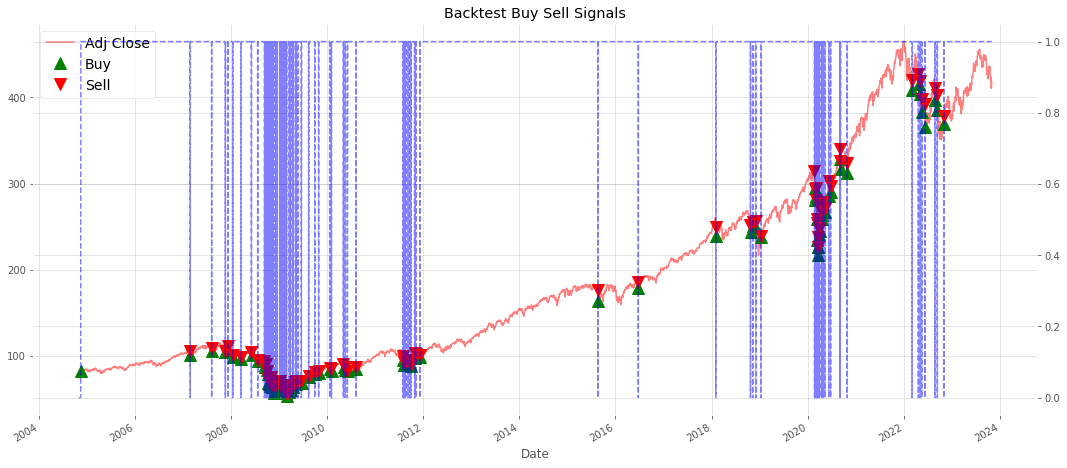

In [31]:
#create dataframe suitable for backtest Class 
reporting_df=pd.concat([spy["Adj Close"],X_traintest1["signal"].fillna(0)],axis=1)
reporting_df.columns=['Adj Close','Position']

#Generate Stats
reporting_df["Position"] = reporting_df["Position"].fillna(0)
Backtest_Strategy1=Backtest(reporting_df,100000,0)
Backtest_Strategy1.plot_all_stats()

## Results from hyperparameters optimization

In [32]:
"""Hyperparameters: 
1) Degree of polynomial features, 
2) Number of variables that could explained most variance 
3) Elastic Net's L1ratio"""

"Hyperparameters: \n1) Degree of polynomial features, \n2) Number of variables that could explained most variance \n3) Elastic Net's L1ratio"

In [34]:
#initialise dataframe to store results of optimization
res1 = pd.DataFrame(columns =['balance', 'degree', 'k', 'penalty_'])

def optimise2(X_traintest, Y_traintest, long_short=True, get_backtest = False, res = res1, degree=3, k=10, penalty_=0, solver= 'saga', capital = 100000): 
        
    Y_traintest_binary = (Y_traintest > 0).astype(int)
    
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_traintest)
    
    index_ = X_traintest.index

    feature_names = poly.get_feature_names_out(input_features=['10years futures', 'vix', 'Volume', 'Volume_3', 'Volume_6', 'Volume_12', 'SPY_3', 'SPY_6', 'SPY_12']) 
    X_poly_df = pd.DataFrame(X_poly, columns=feature_names, index = index_)
    
     # select the top 10 features based on the F-scores
    selector = SelectKBest(score_func=f_regression, k=k) 
    X_selected = selector.fit_transform(X_poly_df, Y_traintest_binary) #Y_traintest_binary
    X_columns = selector.get_feature_names_out()
    X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = index_)
    
    LN = LinearRegression()
    LN.fit(X_selected_df, Y_traintest_binary)
    LN_pred_train = LN.predict(X_selected_df)
    LN_pred_train_df = pd.DataFrame(LN_pred_train, columns = ['predicted'], index = index_) 
    Y_pred_binary = (LN_pred_train_df > 0).astype(int)
    
    if len(Y_pred_binary['predicted'].unique()) == 1:
        return print("Combination: degree = {degree}, polynomial HP {k}, regularization's L1ratio {penalty_}, output only has 1 class of predictions!".format(degree, k, penalty_))
    
    logreg_sk = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver=solver)
    
    logreg_sk.fit(X_selected_df, Y_pred_binary)
    
    Y_pred_logistic = logreg_sk.predict(X_selected_df)
    
    if long_short: 
        signal = Y_pred_logistic
        short_signal = (signal == 0) * -1 
        signals = short_signal + signal

    Y_pred_logistic_df = pd.DataFrame(Y_pred_logistic, columns=['predicted'])
    Y_pred_logistic_df.index = index_
    
    X_traintest3 = X.iloc[12:].copy()
    X_traintest3["signal"] = signals
    X_traintest3['strategy_return'] = X_traintest3["signal"] * Y
    X_traintest3['strategy_account'] = X_traintest3['strategy_return'].cumsum().apply(np.exp) * capital
    X_traintest3['passive_account'] = Y.cumsum().apply(np.exp) * capital

    balance3 = X_traintest3['strategy_account'].dropna()[-1]
    res.loc[len(res)] = [balance3, degree, k, penalty_]
    
    if get_backtest:
        reporting_df2 = pd.concat([spy["Adj Close"], X_traintest3["signal"].fillna(0)],axis=1)
        reporting_df2.columns=['Adj Close','Position']

        return reporting_df2, X_traintest3["signal"]

In [35]:
degree_list = [2,3]
k_list = np.arange(5, 15)
penalty_list = [0, 0.1, 0.2]

combi = [(degree, k, penalty_)
        for degree in degree_list
        for k in k_list
        for penalty_ in penalty_list]

res2 = pd.DataFrame(columns =['account_balance', 'degree', 'k', 'penalty_'])

for degree, k, penalty_ in combi:
    (
    optimise2(X_traintest, 
              Y_traintest, 
              long_short=True, 
              get_backtest = False, 
              res = res2, 
              degree=degree, 
              k=k, 
              penalty_=penalty_, 
              solver= 'saga', 
              capital = 100000)
    )
    
res2.sort_values('account_balance', ascending=False).head(5)

account_balance  degree     k  penalty_
17     2.368483e+09     2.0  10.0       0.2
16     2.368483e+09     2.0  10.0       0.1
15     2.368483e+09     2.0  10.0       0.0
20     2.161086e+09     2.0  11.0       0.2
19     2.161086e+09     2.0  11.0       0.1

+-----------------------+--------------------+
|             Statistic |              Value |
+-----------------------+--------------------+
| Final Account Balance | $ 2,368,482,721.91 |
|    Cummulative return |        2368382.72% |
|         Strategy CAGR |             69.88% |
|          Max Drawdown |            -12.82% |
|          Sharpe Ratio |              2.847 |
|         Sortino Ratio |              6.485 |
+-----------------------+--------------------+


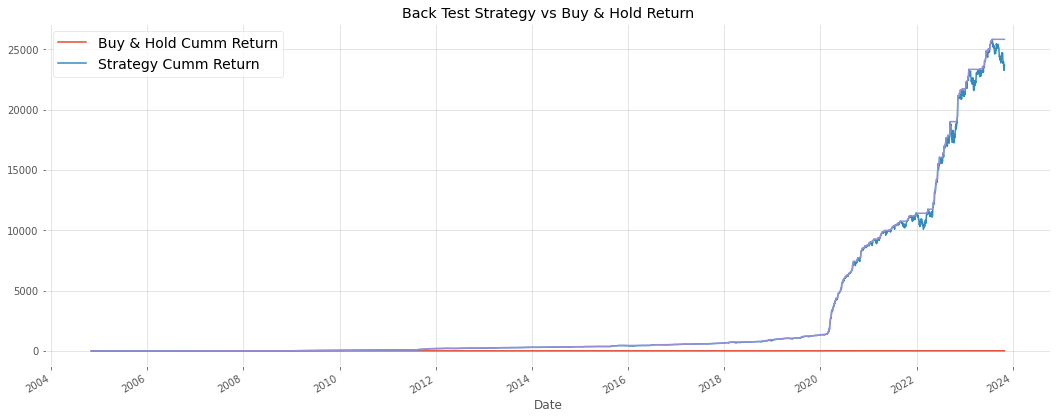

% Return by Quarter:
+------+-----------+----------+----------+-----------+
| year |        Q1 |       Q2 |       Q3 |        Q4 |
+------+-----------+----------+----------+-----------+
| 2004 |       nan |      nan |      nan |   2.41271 |
| 2005 |  -2.02423 |  1.44206 |  3.67826 |   1.73116 |
| 2006 |   4.68742 | -1.53081 |  5.41129 |   6.60955 |
| 2007 |    9.0155 |  6.39319 |  8.22994 |  12.19667 |
| 2008 |   6.12275 |  3.98895 | 35.26566 | 287.06354 |
| 2009 |  82.07353 |  62.4123 | 28.17711 |  18.33459 |
| 2010 |  17.42036 | 10.17488 | 17.51482 |  10.76085 |
| 2011 |   5.89738 |  0.02584 | 55.72734 |  48.08326 |
| 2012 |  12.69093 |  2.23914 |  6.34723 |  -0.38203 |
| 2013 |  10.50267 |  2.93536 |  5.24181 |  10.52478 |
| 2014 |   1.70307 |    5.159 |  1.13475 |   4.90025 |
| 2015 |   3.59625 |  0.20411 | 15.18575 |   7.02048 |
| 2016 |   1.32926 | 10.23134 |  3.77729 |    3.9517 |
| 2017 |   5.92113 |  3.07085 |  4.41556 |   6.76431 |
| 2018 |   7.83609 |  3.55238 |  7.65118 |  

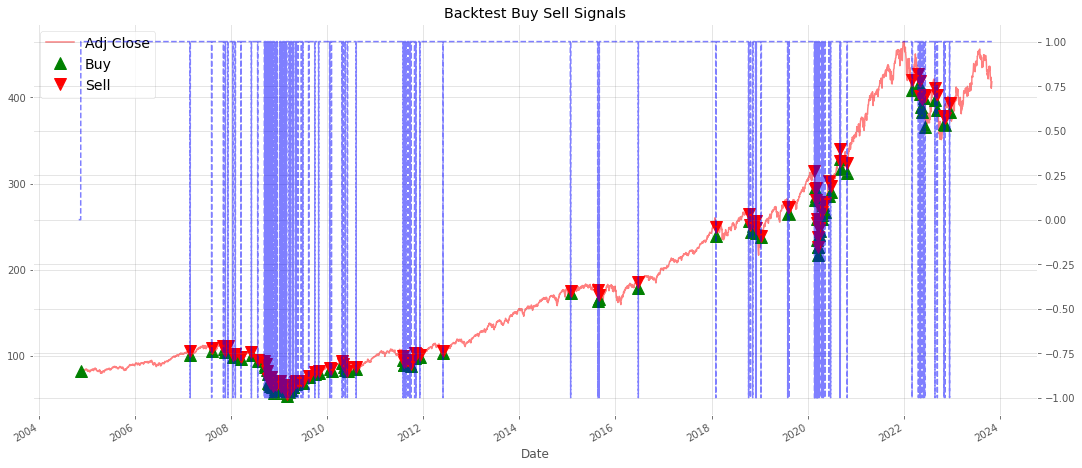

In [36]:
#unpacking the optimized params
account_balance2, degree2, k2, penalty_2 = res2.sort_values('account_balance', ascending=False).iloc[0]

#fit the optimized params into the function to get backtest results
reporting_df2, signal2 =\
(optimise2(X_traintest, 
           Y_traintest, 
           get_backtest = True, 
           res= res2, 
           degree=int(degree2), 
           k=int(k2), 
           penalty_=penalty_2, 
           solver= 'saga', 
           capital = 100000)
)



#Generate Stats
reporting_df2["Position"] = reporting_df2["Position"].fillna(0)
Backtest_Strategy2=Backtest(reporting_df2,100000,0)
Backtest_Strategy2.plot_all_stats()

### ~Strategy 3 Ends

<a id='strategy_4'></a>

# Strategy 4: 

### ~Strategy 4 Ends

<a id='strategy_5'></a>

# Strategy 5: 

### ~Strategy 5 Ends

<a id='Part_4_Analysis_Survivorship_Bias'></a>

# Part 4 Analysis - Survivorship Bias S&P: 

In [66]:
snp_log = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[1]
snp_log.columns=['Date', 'Added-Ticker','Added-Security','Removed-Ticker','Removed-Security','Reason']
snp_log.set_index('Date', inplace=True)
snp_log.index = pd.to_datetime(snp_log.index)

In [67]:
#Companies added between 2004 and 2023
Companies_Added=snp_log[(snp_log.index >'2004-11-1') & (snp_log.index <'2023-10-1')][['Added-Ticker','Added-Security','Reason']]
#Companies_Added[Companies_Added.isnull().any(axis=1)]
Companies_Added=Companies_Added.dropna()
Companies_Added=Companies_Added.sort_values(by='Date')
Companies_Added

Added-Ticker         Added-Security  \
Date                                             
2005-07-01          STZ   Constellation Brands   
2005-11-18         AMZN                 Amazon   
2006-06-02         JNPR       Juniper Networks   
2007-01-10          AVB  AvalonBay Communities   
2007-03-30          KFT            Kraft Foods   
...                 ...                    ...   
2023-05-04         AXON        Axon Enterprise   
2023-06-20         PANW     Palo Alto Networks   
2023-08-25         KVUE                 Kenvue   
2023-09-18         ABNB                 Airbnb   
2023-09-18           BX             Blackstone   

                                                       Reason  
Date                                                           
2005-07-01                    Acquired by Crompton Corp.[245]  
2005-11-18     AT&T Corp. acquired by SBC Communications[244]  
2006-06-02  Albertsons acquired by SuperValu and CVS Corp....  
2007-01-10                          Acquired by Motorola[242]  
2007-03-30                                 Taken Private[241]  
...                                                       ...  
2023-05-04  The Federal Deposit Insurance Corporation (FDI...  
2023-06-20                   Market capitalization change.[8]  
2023-08-25  S&P 500 and S&P 100 constituent Johnson & John...  
2023-09-18                   Market capitalization change.[6]  
2023-09-18                   Market capitalization change.[6]  

[306 rows x 3 columns]

In [68]:
#Companies Removed between 2004 and 2023
Companies_Removed=snp_log[(snp_log.index >'2004-11-1') & (snp_log.index <'2023-10-1')][['Removed-Ticker','Removed-Security','Reason']]
#Companies_Removed[Companies_Removed.isnull().any(axis=1)]
Companies_Removed=Companies_Removed.dropna()
Companies_Removed=Companies_Removed.sort_values(by='Date')
Companies_Removed

Removed-Ticker       Removed-Security  \
Date                                               
2005-07-01            GLK   Great Lakes Chemical   
2005-11-18              T       AT&T Corporation   
2006-06-02            ABS             Albertsons   
2007-01-10            SBL    Symbol Technologies   
2007-03-30            TSG      Sabre Corporation   
...                   ...                    ...   
2023-05-04            FRC    First Republic Bank   
2023-06-20           DISH           Dish Network   
2023-08-25            AAP     Advance Auto Parts   
2023-09-18            NWL      Newell Brands Inc   
2023-09-18            LNC  Lincoln National Corp   

                                                       Reason  
Date                                                           
2005-07-01                    Acquired by Crompton Corp.[245]  
2005-11-18     AT&T Corp. acquired by SBC Communications[244]  
2006-06-02  Albertsons acquired by SuperValu and CVS Corp....  
2007-01-10                          Acquired by Motorola[242]  
2007-03-30                                 Taken Private[241]  
...                                                       ...  
2023-05-04  The Federal Deposit Insurance Corporation (FDI...  
2023-06-20                   Market capitalization change.[8]  
2023-08-25  S&P 500 and S&P 100 constituent Johnson & John...  
2023-09-18                   Market capitalization change.[6]  
2023-09-18                   Market capitalization change.[6]  

[301 rows x 3 columns]

In [69]:
Companies_Removed['count']=1
Companies_Removed['count'].groupby(by='Date').sum().cumsum()
date_range = pd.date_range(start='2004-11-01', end='2023-10-31', freq='D')
survivor_companies=pd.DataFrame(index=date_range)
survivor_companies=pd.concat([survivor_companies,Companies_Removed['count'].groupby(by='Date').sum().cumsum()],axis=1)
survivor_companies=survivor_companies.ffill()
survivor_companies=survivor_companies.fillna(0)
survivor_companies['count']=500-survivor_companies['count']
survivor_companies

count
2004-11-01  500.0
2004-11-02  500.0
2004-11-03  500.0
2004-11-04  500.0
2004-11-05  500.0
...           ...
2023-10-27  199.0
2023-10-28  199.0
2023-10-29  199.0
2023-10-30  199.0
2023-10-31  199.0

[6939 rows x 1 columns]

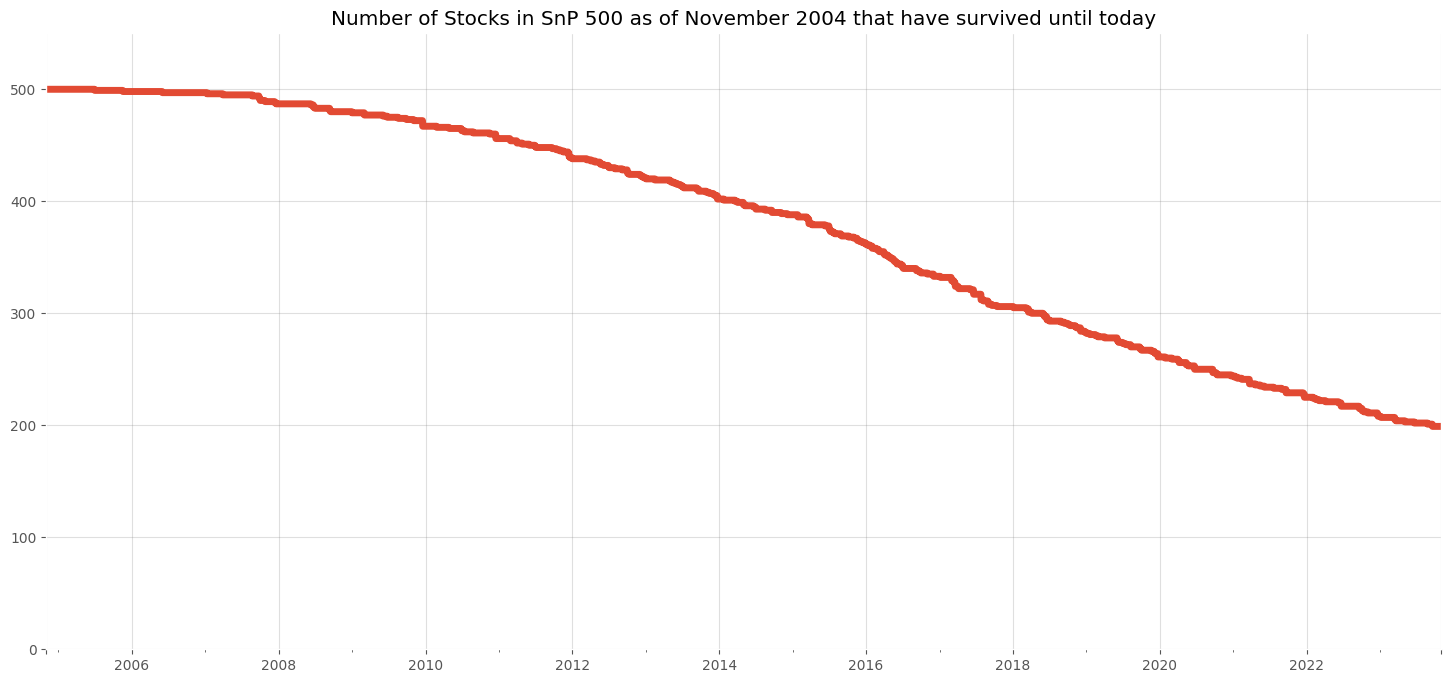

In [70]:
ax=\
(
    survivor_companies['count']
    .plot(figsize=[18,8]
         ,lw=5.0)
)

ax.set_title('Number of Stocks in SnP 500 as of November 2004 that have survived until today')
ax.set_ylim(0,550)
plt.show()

In [71]:
snp_constituent= pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
snp_constituent.set_index('Date added', inplace=True)
snp_constituent=snp_constituent.sort_values(by='Date added')
snp_constituent_survived=snp_constituent[snp_constituent.index<'2004-11-01']
snp_constituent_survived

Symbol                  Security             GICS Sector  \
Date added                                                            
1957-03-04    MMM                        3M             Industrials   
1957-03-04    XOM                ExxonMobil                  Energy   
1957-03-04    EXC                    Exelon               Utilities   
1957-03-04    ETR                   Entergy               Utilities   
1957-03-04   SPGI                S&P Global              Financials   
...           ...                       ...                     ...   
2004-02-23    MTB                  M&T Bank              Financials   
2004-04-23   VTRS                   Viatris             Health Care   
2004-07-01   GILD           Gilead Sciences             Health Care   
2004-08-03    TMO  Thermo Fisher Scientific             Health Care   
2004-09-01    TPR            Tapestry, Inc.  Consumer Discretionary   

                              GICS Sub-Industry     Headquarters Location  \
Date added                                                                  
1957-03-04             Industrial Conglomerates     Saint Paul, Minnesota   
1957-03-04                 Integrated Oil & Gas             Irving, Texas   
1957-03-04                      Multi-Utilities         Chicago, Illinois   
1957-03-04                   Electric Utilities    New Orleans, Louisiana   
1957-03-04           Financial Exchanges & Data   New York City, New York   
...                                         ...                       ...   
2004-02-23                       Regional Banks         Buffalo, New York   
2004-04-23                      Pharmaceuticals  Pittsburgh, Pennsylvania   
2004-07-01                        Biotechnology   Foster City, California   
2004-08-03       Life Sciences Tools & Services    Waltham, Massachusetts   
2004-09-01  Apparel, Accessories & Luxury Goods   New York City, New York   

                CIK      Founded  
Date added                        
1957-03-04    66740         1902  
1957-03-04    34088         1999  
1957-03-04  1109357         2000  
1957-03-04    65984         1913  
1957-03-04    64040         1917  
...             ...          ...  
2004-02-23    36270         1856  
2004-04-23  1792044         1961  
2004-07-01   882095         1987  
2004-08-03    97745  2006 (1902)  
2004-09-01  1116132         2017  

[228 rows x 7 columns]

In [72]:
tickers_survived=snp_constituent_survived['Symbol'].to_list()

In [73]:
start="2004-11-1"
end="2023-11-1"
tickers_survived_data=pdr.get_data_yahoo(tickers_survived,start,end)

[*********************100%***********************]  228 of 228 completed

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted


In [74]:
tickers_survived_data =tickers_survived_data.loc[:,('Adj Close',)]

In [75]:
tickers_survived_data

A        AAPL        ABT        ADBE         ADI  \
Date                                                                    
2004-11-01   15.017413    0.793943  13.156026   28.158575   25.784924   
2004-11-02   15.145041    0.809837  13.023663   28.503435   25.573900   
2004-11-03   15.096419    0.837235  13.423824   28.568409   24.921591   
2004-11-04   15.169350    0.824217  13.682385   29.043217   25.298901   
2004-11-05   15.321286    0.828304  13.682385   29.228140   25.330875   
...                ...         ...        ...         ...         ...   
2023-10-25  103.400002  170.874893  93.570000  521.140015  159.789993   
2023-10-26  104.309998  166.670425  93.980003  514.280029  160.860001   
2023-10-27  102.769997  167.998672  92.849998  508.119995  160.570007   
2023-10-30  101.169998  170.065933  93.000000  526.940002  155.880005   
2023-10-31  103.370003  170.545319  94.550003  532.059998  157.330002   

                  ADM         ADP        ADSK        AEE        AEP  ...  \
Date                                                                 ...   
2004-11-01  12.190432   22.177599   26.820629  21.656403  15.458869  ...   
2004-11-02  12.119371   22.390106   27.065409  21.363810  15.118234  ...   
2004-11-03  12.371313   22.329391   27.639885  21.764429  15.650172  ...   
2004-11-04  12.603884   22.643101   28.793835  22.228086  16.177450  ...   
2004-11-05  12.817070   22.577333   28.798832  21.890478  16.032806  ...   
...               ...         ...         ...        ...        ...  ...   
2023-10-25  70.612259  218.330002  200.210007  76.849998  74.511421  ...   
2023-10-26  71.407326  218.839996  196.119995  77.050003  74.916794  ...   
2023-10-27  69.608482  214.839996  195.149994  75.379997  74.086258  ...   
2023-10-30  70.979980  216.080002  197.789993  75.040001  74.560860  ...   
2023-10-31  71.129051  218.220001  197.630005  75.709999  74.689392  ...   

                    WM        WMB         WMT        WRK         WY  \
Date                                                                  
2004-11-01   16.769756   4.622966   36.286884        NaN  12.177520   
2004-11-02   16.799194   4.586043   36.489029        NaN  12.146544   
2004-11-03   16.893370   4.718969   36.711403        NaN  12.359475   
2004-11-04   17.222992   4.840822   37.910862        NaN  12.669189   
2004-11-05   17.446669   4.896209   38.052364        NaN  12.678865   
...                ...        ...         ...        ...        ...   
2023-10-25  164.070007  34.459999  162.759995  34.356747  28.610001   
2023-10-26  162.820007  34.580002  161.770004  34.961937  29.010000   
2023-10-27  161.380005  34.049999  161.169998  34.922249  28.620001   
2023-10-30  162.750000  34.230000  163.020004  35.150436  28.549999   
2023-10-31  164.330002  34.400002  163.410004  35.646488  28.690001   

                  XEL         XOM         YUM         ZBH       ZION  
Date                                                                  
2004-11-01   8.413717   25.852715   11.088285   67.127815  47.096996  
2004-11-02   8.364568   25.646187   11.042460   66.934319  46.706173  
2004-11-03   8.526753   26.091019   11.263968   68.491127  47.182266  
2004-11-04   8.684013   26.578199   11.640792   70.223885  47.608608  
2004-11-05   8.674187   26.684107   11.712082   71.833443  47.175163  
...               ...         ...         ...         ...        ...  
2023-10-25  59.470001  107.606010  120.309998  103.639999  29.273745  
2023-10-26  59.770000  106.624985  118.750000  103.120003  30.083887  
2023-10-27  58.310001  104.593567  119.440002  103.190002  29.095911  
2023-10-30  58.740002  104.920570  119.870003  103.410004  29.619537  
2023-10-31  59.270000  104.890846  120.860001  104.410004  30.479076  

[4783 rows x 228 columns]

In [76]:
missing_values =\
(
    tickers_survived_data
    .isnull() # True (1) vs. False (0)
    .mean()
    .sort_values(ascending = False)
)

missing_values.head(10)

BF.B    1.000000
HWM     0.631821
WRK     0.560109
PARA    0.057704
A       0.000000
NOC     0.000000
NTRS    0.000000
NTAP    0.000000
NSC     0.000000
NKE     0.000000
dtype: float64

In [77]:
drop_list =\
(
    sorted(list(missing_values[missing_values > 0.01]
                .index)
          )
)

drop_list

['BF.B', 'HWM', 'PARA', 'WRK']

In [78]:
tickers_survived_data =\
(
    tickers_survived_data
    .drop(labels = drop_list,
          axis = 1)
)

tickers_survived_data

A        AAPL        ABT        ADBE         ADI  \
Date                                                                    
2004-11-01   15.017413    0.793943  13.156026   28.158575   25.784924   
2004-11-02   15.145041    0.809837  13.023663   28.503435   25.573900   
2004-11-03   15.096419    0.837235  13.423824   28.568409   24.921591   
2004-11-04   15.169350    0.824217  13.682385   29.043217   25.298901   
2004-11-05   15.321286    0.828304  13.682385   29.228140   25.330875   
...                ...         ...        ...         ...         ...   
2023-10-25  103.400002  170.874893  93.570000  521.140015  159.789993   
2023-10-26  104.309998  166.670425  93.980003  514.280029  160.860001   
2023-10-27  102.769997  167.998672  92.849998  508.119995  160.570007   
2023-10-30  101.169998  170.065933  93.000000  526.940002  155.880005   
2023-10-31  103.370003  170.545319  94.550003  532.059998  157.330002   

                  ADM         ADP        ADSK        AEE        AEP  ...  \
Date                                                                 ...   
2004-11-01  12.190432   22.177599   26.820629  21.656403  15.458869  ...   
2004-11-02  12.119371   22.390106   27.065409  21.363810  15.118234  ...   
2004-11-03  12.371313   22.329391   27.639885  21.764429  15.650172  ...   
2004-11-04  12.603884   22.643101   28.793835  22.228086  16.177450  ...   
2004-11-05  12.817070   22.577333   28.798832  21.890478  16.032806  ...   
...               ...         ...         ...        ...        ...  ...   
2023-10-25  70.612259  218.330002  200.210007  76.849998  74.511421  ...   
2023-10-26  71.407326  218.839996  196.119995  77.050003  74.916794  ...   
2023-10-27  69.608482  214.839996  195.149994  75.379997  74.086258  ...   
2023-10-30  70.979980  216.080002  197.789993  75.040001  74.560860  ...   
2023-10-31  71.129051  218.220001  197.630005  75.709999  74.689392  ...   

                   WHR          WM        WMB         WMT         WY  \
Date                                                                   
2004-11-01   33.760960   16.769756   4.622966   36.286884  12.177520   
2004-11-02   34.186321   16.799194   4.586043   36.489029  12.146544   
2004-11-03   34.815628   16.893370   4.718969   36.711403  12.359475   
2004-11-04   35.835339   17.222992   4.840822   37.910862  12.669189   
2004-11-05   36.388897   17.446669   4.896209   38.052364  12.678865   
...                ...         ...        ...         ...        ...   
2023-10-25  123.697884  164.070007  34.459999  162.759995  28.610001   
2023-10-26  104.120514  162.820007  34.580002  161.770004  29.010000   
2023-10-27  100.545761  161.380005  34.049999  161.169998  28.620001   
2023-10-30  100.969215  162.750000  34.230000  163.020004  28.549999   
2023-10-31  102.968315  164.330002  34.400002  163.410004  28.690001   

                  XEL         XOM         YUM         ZBH       ZION  
Date                                                                  
2004-11-01   8.413717   25.852715   11.088285   67.127815  47.096996  
2004-11-02   8.364568   25.646187   11.042460   66.934319  46.706173  
2004-11-03   8.526753   26.091019   11.263968   68.491127  47.182266  
2004-11-04   8.684013   26.578199   11.640792   70.223885  47.608608  
2004-11-05   8.674187   26.684107   11.712082   71.833443  47.175163  
...               ...         ...         ...         ...        ...  
2023-10-25  59.470001  107.606010  120.309998  103.639999  29.273745  
2023-10-26  59.770000  106.624985  118.750000  103.120003  30.083887  
2023-10-27  58.310001  104.593567  119.440002  103.190002  29.095911  
2023-10-30  58.740002  104.920570  119.870003  103.410004  29.619537  
2023-10-31  59.270000  104.890846  120.860001  104.410004  30.479076  

[4783 rows x 224 columns]

In [79]:
tickers_survived_return=tickers_survived_data.pct_change()
tickers_survived_return

A      AAPL       ABT      ADBE       ADI       ADM  \
Date                                                                     
2004-11-01       NaN       NaN       NaN       NaN       NaN       NaN   
2004-11-02  0.008499  0.020019 -0.010061  0.012247 -0.008184 -0.005829   
2004-11-03 -0.003210  0.033832  0.030726  0.002280 -0.025507  0.020788   
2004-11-04  0.004831 -0.015550  0.019261  0.016620  0.015140  0.018799   
2004-11-05  0.010016  0.004959  0.000000  0.006367  0.001264  0.016914   
...              ...       ...       ...       ...       ...       ...   
2023-10-25 -0.021204 -0.013492 -0.013079 -0.034139 -0.031165  0.022744   
2023-10-26  0.008801 -0.024606  0.004382 -0.013163  0.006696  0.011260   
2023-10-27 -0.014764  0.007969 -0.012024 -0.011978 -0.001803 -0.025191   
2023-10-30 -0.015569  0.012305  0.001616  0.037039 -0.029208  0.019703   
2023-10-31  0.021746  0.002819  0.016667  0.009716  0.009302  0.002100   

                 ADP      ADSK       AEE       AEP  ...       WHR        WM  \
Date                                                ...                       
2004-11-01       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2004-11-02  0.009582  0.009127 -0.013511 -0.022035  ...  0.012599  0.001755   
2004-11-03 -0.002712  0.021225  0.018752  0.035185  ...  0.018408  0.005606   
2004-11-04  0.014049  0.041749  0.021303  0.033692  ...  0.029289  0.019512   
2004-11-05 -0.002905  0.000174 -0.015188 -0.008941  ...  0.015447  0.012987   
...              ...       ...       ...       ...  ...       ...       ...   
2023-10-25 -0.091994 -0.023556  0.006417  0.008295  ... -0.011334  0.061049   
2023-10-26  0.002336 -0.020429  0.002603  0.005440  ... -0.158268 -0.007619   
2023-10-27 -0.018278 -0.004946 -0.021674 -0.011086  ... -0.034333 -0.008844   
2023-10-30  0.005772  0.013528 -0.004510  0.006406  ...  0.004212  0.008489   
2023-10-31  0.009904 -0.000809  0.008929  0.001724  ...  0.019799  0.009708   

                 WMB       WMT        WY       XEL       XOM       YUM  \
Date                                                                     
2004-11-01       NaN       NaN       NaN       NaN       NaN       NaN   
2004-11-02 -0.007987  0.005571 -0.002544 -0.005842 -0.007989 -0.004133   
2004-11-03  0.028985  0.006094  0.017530  0.019390  0.017345  0.020060   
2004-11-04  0.025822  0.032673  0.025059  0.018443  0.018672  0.033454   
2004-11-05  0.011442  0.003733  0.000764 -0.001132  0.003985  0.006124   
...              ...       ...       ...       ...       ...       ...   
2023-10-25  0.000000 -0.003002 -0.011403  0.006601  0.001845  0.003336   
2023-10-26  0.003482 -0.006083  0.013981  0.005045 -0.009117 -0.012966   
2023-10-27 -0.015327 -0.003709 -0.013444 -0.024427 -0.019052  0.005811   
2023-10-30  0.005286  0.011479 -0.002446  0.007374  0.003126  0.003600   
2023-10-31  0.004966  0.002392  0.004904  0.009023 -0.000283  0.008259   

                 ZBH      ZION  
Date                            
2004-11-01       NaN       NaN  
2004-11-02 -0.002883 -0.008298  
2004-11-03  0.023259  0.010193  
2004-11-04  0.025299  0.009036  
2004-11-05  0.022920 -0.009104  
...              ...       ...  
2023-10-25 -0.011446 -0.007703  
2023-10-26 -0.005017  0.027675  
2023-10-27  0.000679 -0.032841  
2023-10-30  0.002132  0.017997  
2023-10-31  0.009670  0.029019  

[4783 rows x 224 columns]

In [80]:
tickers_survived_return['Portfolio Return'] = tickers_survived_return.mean(axis=1)
tickers_survived_return

A      AAPL       ABT      ADBE       ADI       ADM  \
Date                                                                     
2004-11-01       NaN       NaN       NaN       NaN       NaN       NaN   
2004-11-02  0.008499  0.020019 -0.010061  0.012247 -0.008184 -0.005829   
2004-11-03 -0.003210  0.033832  0.030726  0.002280 -0.025507  0.020788   
2004-11-04  0.004831 -0.015550  0.019261  0.016620  0.015140  0.018799   
2004-11-05  0.010016  0.004959  0.000000  0.006367  0.001264  0.016914   
...              ...       ...       ...       ...       ...       ...   
2023-10-25 -0.021204 -0.013492 -0.013079 -0.034139 -0.031165  0.022744   
2023-10-26  0.008801 -0.024606  0.004382 -0.013163  0.006696  0.011260   
2023-10-27 -0.014764  0.007969 -0.012024 -0.011978 -0.001803 -0.025191   
2023-10-30 -0.015569  0.012305  0.001616  0.037039 -0.029208  0.019703   
2023-10-31  0.021746  0.002819  0.016667  0.009716  0.009302  0.002100   

                 ADP      ADSK       AEE       AEP  ...        WM       WMB  \
Date                                                ...                       
2004-11-01       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2004-11-02  0.009582  0.009127 -0.013511 -0.022035  ...  0.001755 -0.007987   
2004-11-03 -0.002712  0.021225  0.018752  0.035185  ...  0.005606  0.028985   
2004-11-04  0.014049  0.041749  0.021303  0.033692  ...  0.019512  0.025822   
2004-11-05 -0.002905  0.000174 -0.015188 -0.008941  ...  0.012987  0.011442   
...              ...       ...       ...       ...  ...       ...       ...   
2023-10-25 -0.091994 -0.023556  0.006417  0.008295  ...  0.061049  0.000000   
2023-10-26  0.002336 -0.020429  0.002603  0.005440  ... -0.007619  0.003482   
2023-10-27 -0.018278 -0.004946 -0.021674 -0.011086  ... -0.008844 -0.015327   
2023-10-30  0.005772  0.013528 -0.004510  0.006406  ...  0.008489  0.005286   
2023-10-31  0.009904 -0.000809  0.008929  0.001724  ...  0.009708  0.004966   

                 WMT        WY       XEL       XOM       YUM       ZBH  \
Date                                                                     
2004-11-01       NaN       NaN       NaN       NaN       NaN       NaN   
2004-11-02  0.005571 -0.002544 -0.005842 -0.007989 -0.004133 -0.002883   
2004-11-03  0.006094  0.017530  0.019390  0.017345  0.020060  0.023259   
2004-11-04  0.032673  0.025059  0.018443  0.018672  0.033454  0.025299   
2004-11-05  0.003733  0.000764 -0.001132  0.003985  0.006124  0.022920   
...              ...       ...       ...       ...       ...       ...   
2023-10-25 -0.003002 -0.011403  0.006601  0.001845  0.003336 -0.011446   
2023-10-26 -0.006083  0.013981  0.005045 -0.009117 -0.012966 -0.005017   
2023-10-27 -0.003709 -0.013444 -0.024427 -0.019052  0.005811  0.000679   
2023-10-30  0.011479 -0.002446  0.007374  0.003126  0.003600  0.002132   
2023-10-31  0.002392  0.004904  0.009023 -0.000283  0.008259  0.009670   

                ZION  Portfolio Return  
Date                                    
2004-11-01       NaN               NaN  
2004-11-02 -0.008298         -0.001317  
2004-11-03  0.010193          0.012683  
2004-11-04  0.009036          0.017614  
2004-11-05 -0.009104          0.003163  
...              ...               ...  
2023-10-25 -0.007703         -0.005554  
2023-10-26  0.027675         -0.000959  
2023-10-27 -0.032841         -0.012986  
2023-10-30  0.017997          0.009030  
2023-10-31  0.029019          0.008226  

[4783 rows x 225 columns]

In [81]:
start="2004-11-1"
end="2023-11-1"
spy_data=pdr.get_data_yahoo('SPY',start,end)
spy_data['Return']=spy_data['Adj Close'].pct_change()
spy_data

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-11-01  113.559998  113.839996  113.199997  113.510002   78.617935   
2004-11-02  113.669998  114.570000  113.220001  113.550003   78.645630   
2004-11-03  115.029999  115.360001  114.239998  114.980003   79.636055   
2004-11-04  114.779999  116.669998  114.680000  116.550003   80.723473   
2004-11-05  117.050003  117.639999  116.489998  117.279999   81.229065   
...                ...         ...         ...         ...         ...   
2023-10-25  421.890015  421.920013  417.019989  417.549988  417.549988   
2023-10-26  416.450012  417.329987  411.600006  412.549988  412.549988   
2023-10-27  414.190002  414.600006  409.209991  410.679993  410.679993   
2023-10-30  413.559998  416.679993  412.220001  415.589996  415.589996   
2023-10-31  416.179993  418.529999  414.209991  418.200012  418.200012   

               Volume    Return  
Date                             
2004-11-01   36720900       NaN  
2004-11-02   56210000  0.000352  
2004-11-03   76960200  0.012594  
2004-11-04   55350300  0.013655  
2004-11-05   63287200  0.006263  
...               ...       ...  
2023-10-25   94223200 -0.014352  
2023-10-26  115156800 -0.011975  
2023-10-27  107367700 -0.004533  
2023-10-30   86562700  0.011956  
2023-10-31   79665200  0.006280  

[4783 rows x 7 columns]

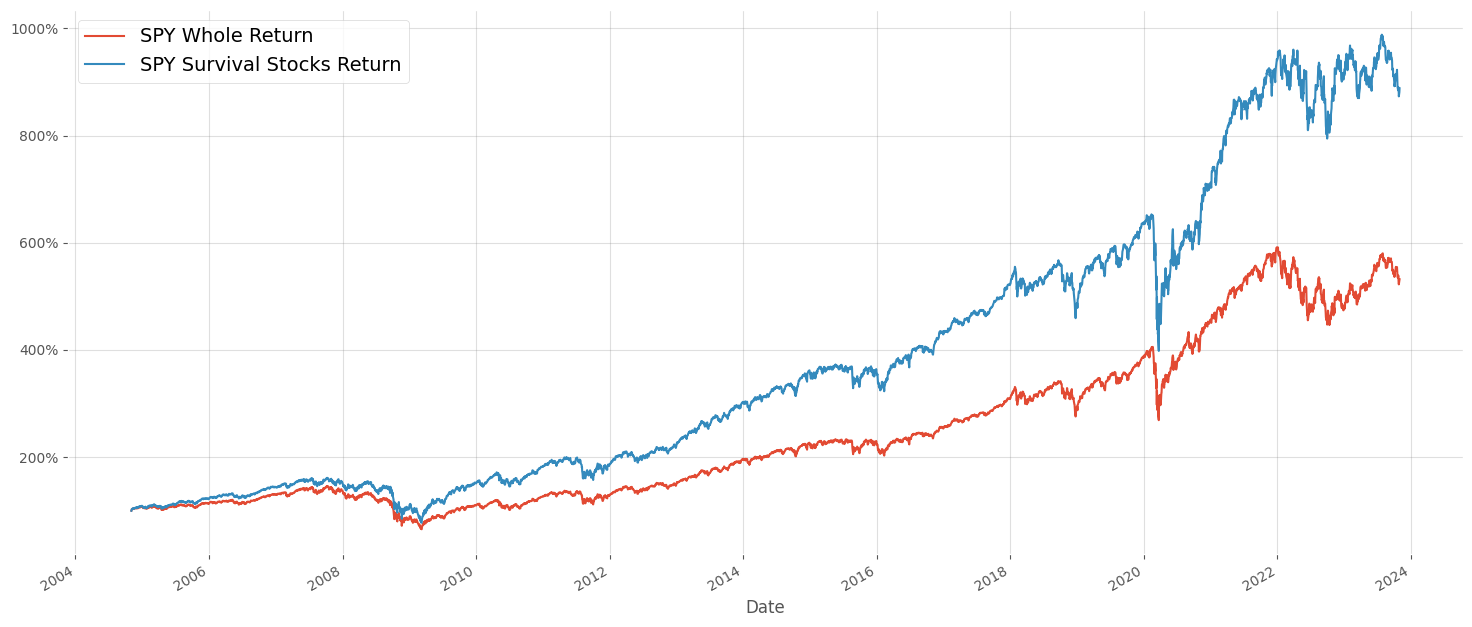

In [82]:
ax=\
(
    spy_data['Return']
    .add(1)
    .cumprod()
    .multiply(100)
    .plot(figsize=[18,8]
         ,label='SPY Whole Return')
)

ax=\
(
    tickers_survived_return['Portfolio Return']
    .add(1)
    .cumprod()
    .multiply(100)
    .plot(figsize=[18,8]
         ,label='SPY Survival Stocks Return')
)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
plt.legend()
plt.show()

### ~ Part 4 Analysis - Survivorship bias ends

<a id='Part_4_Analysis_MarketRegime'></a>

# Part 4 Analysis - Market Regime Change

In [ ]:
#Dependencies

#time series standardardisation
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# KMeans
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from sklearn.metrics import pairwise_distances

In [ ]:
start_date = dt.datetime(2004,11,1)
end_date = dt.datetime(2023,11,1)

spy = pdr.get_data_yahoo("SPY", start = start_date, end = end_date)

vix_ticker = "^VIX"
vix = pdr.get_data_yahoo(vix_ticker, start=start_date, end=end_date)

spy_vix = pd.concat([spy["Adj Close"], vix["Adj Close"]], axis = 1)

Y = np.log(spy["Adj Close"]).diff(1)
Y.name = "Y_pred"

spy_vix

In [ ]:
regime_dict1 = {}

inertia_list1 = []

#clustering to detect regime change 
max_clusters = len(pd.unique(spy_vix.index.year)) 

X_scaled = TimeSeriesScalerMeanVariance().fit_transform(spy_vix)
X_scaled = X_scaled.reshape(X_scaled.shape[0], -1)

# Compute DTW distances
dtw_distances = pairwise_distances(X_scaled, metric=dtw)

In [ ]:
regime_dict1 = {}

inertia_list1 = []

#clustering to detect regime change 
max_clusters = len(pd.unique(spy_vix.index.year)) 

X_scaled = TimeSeriesScalerMeanVariance().fit_transform(spy_vix)
X_scaled = X_scaled.reshape(X_scaled.shape[0], -1)

# Compute DTW distances
dtw_distances = pairwise_distances(X_scaled, metric=dtw)


In [ ]:
for num_cluster in range(2, max_clusters):
    kmeans_model = KMeans(n_clusters=num_cluster, random_state=627)
    kmeans_model.fit(dtw_distances)
    inertia_list1.append(kmeans_model.inertia_)
    spy_vix['cluster_label'] =\
    (kmeans_model
             .fit_predict(dtw_distances)
    )
    
    regime_dict1[num_cluster] = spy_vix['cluster_label']
    print(" ")
    print("iteration number {} done!".format(num_cluster))
    
    
# Plot the elbow curve
plt.plot(np.arange(len(inertia_list1)), inertia_list1, marker='o')
plt.xticks(np.arange(2, 20, 2))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

def find_optimal_clusters(inertia_values):
    # Calculate the second derivative of the inertia values
    second_derivative = np.gradient(np.gradient(inertia_values))
    
    # Find the index of the maximum value in the second derivative
    optimal_index = np.argmax(second_derivative)
    
    # The optimal number of clusters is the index + 2 (since indexing starts from 0 and we start from k=2)
    optimal_clusters = optimal_index + 2
    
    return optimal_clusters

# Use the function to find the optimal number of clusters
optimal_clusters1 = find_optimal_clusters(inertia_list1)

print(f"The optimal number of clusters based on the elbow method is: {optimal_clusters1}")

regime_dict_df1 = pd.DataFrame(regime_dict1, columns = regime_dict1.keys())
regime_dict_df1[optimal_clusters1].value_counts()

In [ ]:
Y.cumsum().apply(np.exp).plot(figsize = [16, 6])

regime_dict_df1[optimal_clusters1][regime_dict_df1[optimal_clusters1] == 0].plot(figsize = [16, 6],
          marker = "^", 
          color = "green",
          markersize = 1,
          alpha = 0.2,
          label= "cluster label 0"                                                           
         )

regime_dict_df1[optimal_clusters1][regime_dict_df1[optimal_clusters1] == 1].plot(figsize = [16, 6],
          marker = "^", 
          color = "blue",
          markersize = 1,
          alpha = 0.2,
          label= "cluster label 1" 
         )

regime_dict_df1[optimal_clusters1][regime_dict_df1[optimal_clusters1] == 2].plot(figsize = [16, 6],
          marker = "^", 
          color = "black",
          markersize = 1,
          alpha = 0.2,
          label= "cluster label 2" 
         )

plt.legend()

plt.show()

In [ ]:
regime = regime_dict_df1[3].drop_duplicates(keep="first")
regime.name = "regime label"
regime.to_frame()

In [ ]:
regime2 = regime_dict_df1[3].drop_duplicates(keep="last")
regime2.name = "regime label"
regime2.to_frame()

#### ~ Part 4 Analysis - Market regime change ends

## End